# Paths

In [1]:
UTILS_PATH = '../../../src/utils'

# Imports 

In [2]:
import sys
sys.path.append(UTILS_PATH)

In [3]:
from my_loss import GershgorinPolyRegressionLoss

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Logging
import wandb
from tqdm import tqdm

In [5]:
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'
device

'cpu'

# Data

In [6]:
ds_path = '../../../datasets/ds02'

In [7]:
X_train = torch.utils.data.TensorDataset(torch.load(ds_path + '/train.pt').type(torch.float).to(device))
X_valid = torch.utils.data.TensorDataset(torch.load(ds_path + '/test.pt').type(torch.float).to(device))

In [8]:
train_dataloader = DataLoader(X_train, batch_size=32, shuffle=True, drop_last=True)
valid_dataloader = DataLoader(X_valid, batch_size=32, shuffle=False)

# Spectrum drawer

In [9]:
from spectrum_drawers import draw_spectrum

In [10]:
@torch.no_grad()
def draw_random_spectrums(net, val_ds, h=3, w=3, mode='eye_min_t_c_inv', path='./spectrum.svg', indices=None):
    
    if indices is None:
        indices = np.random.choice(len(val_ds), h * w, replace=False)
    
    assert len(indices) == h * w
        
    input_data = val_ds[indices][0]

    net.eval()
    output_data = net(input_data)
    
    input_data = input_data.cpu().detach().numpy()
    output_data = output_data.cpu().detach().numpy()
    
    draw_spectrum(input_data, output_data, h, w, mode, path)

# Model

In [11]:
class MyPerceptronFD(nn.Module):
    
    def __init__(self, dim=64):
        
        super().__init__()
        self.dim = dim
        
        self.fc1 = nn.Linear(dim, 2 * dim)
        self.ac1 = nn.ReLU()
        
        self.fc2 = nn.Linear(2 * dim, 2 * dim)
        self.ac2 = nn.ReLU()
        
        self.fc3 = nn.Linear(2 * dim, 2 * dim)
        self.ac3 = nn.ReLU()
        
        self.fc4 = nn.Linear(2 * dim, dim)
        
    def forward(self, x):
        
        x = self.ac1(self.fc1(x))
        x = self.ac2(self.fc2(x))
        x = self.ac3(self.fc3(x))
        
        return self.fc4(x)

# Train loop

In [12]:
val_indices = np.random.choice(len(X_valid), 4 * 4, replace=False)

In [13]:
@torch.no_grad()
def evaluate(net, 
             model_name,
             epoch_num, 
             device):
    
    net.eval()
    draw_random_spectrums(net, X_valid, 4, 4, 
                          mode='t_c_inv',
                          path=f'./{model_name}/spectrum_epoch{epoch_num}.svg', 
                          indices=val_indices)

def train(epoch_num, 
          net, 
          optimizer, 
          criterion,
          scheduler,
          train_dataloader, 
          valid_dataloader, 
          device, 
          name,
          model_name):

    wandb.init(project="loss_choice_02", name=name)
    global_step = 0
    net = net.to(device)

    iters_per_epoch = len(train_dataloader)

    for epoch in tqdm(range(epoch_num)):
        
        avg_valid_eig_module_pred  = evaluate(net, model_name, epoch, device)
                
        net.train()
        
        for inputs in train_dataloader:
            
            inputs = inputs[0].to(device)
            
            outputs = net(inputs)
            
            loss = criterion(inputs, outputs)
            loss.backward()
            
            optimizer.step()
            
            wandb.log({"train/loss": loss.item()}, step=global_step)

            global_step += 1
            
        scheduler.step()

    wandb.finish()

# GershgorinPolyRegressionLoss

In [14]:
net = MyPerceptronFD(64)

criterion = GershgorinPolyRegressionLoss(distr=lambda: 7,
                                         rad_num=5, arg_num=5, 
                                         strategy='exact',
                                         alpha=1.,
                                         lambda_reg=1e-3)

optimizer = optim.Adam(net.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

wandb: Currently logged in as: s02210401 (cmcmsu). Use `wandb login --relogin` to force relogin


 40%|████████▍            | 20/50 [17:45<28:15, 56.53s/it]/home/egor/desktop/tmp/precondnn/exps/loss_choice_exps/exp02/../../../src/utils/spectrum_drawers.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(h, w, figsize=(3 * h, 3 * w))
100%|█████████████████████| 50/50 [44:50<00:00, 53.81s/it]


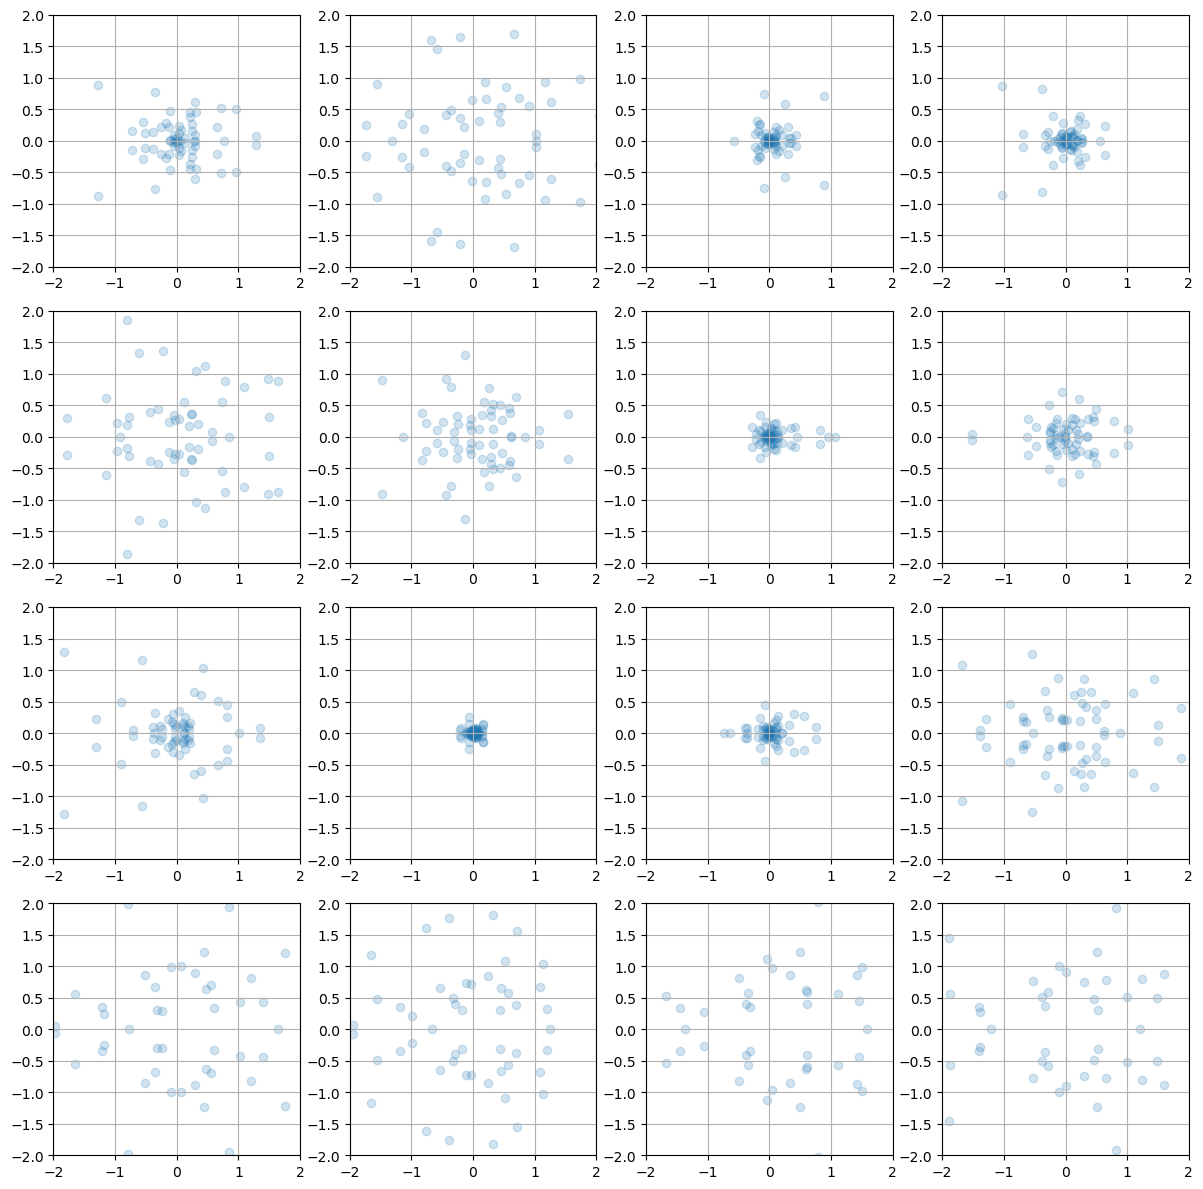

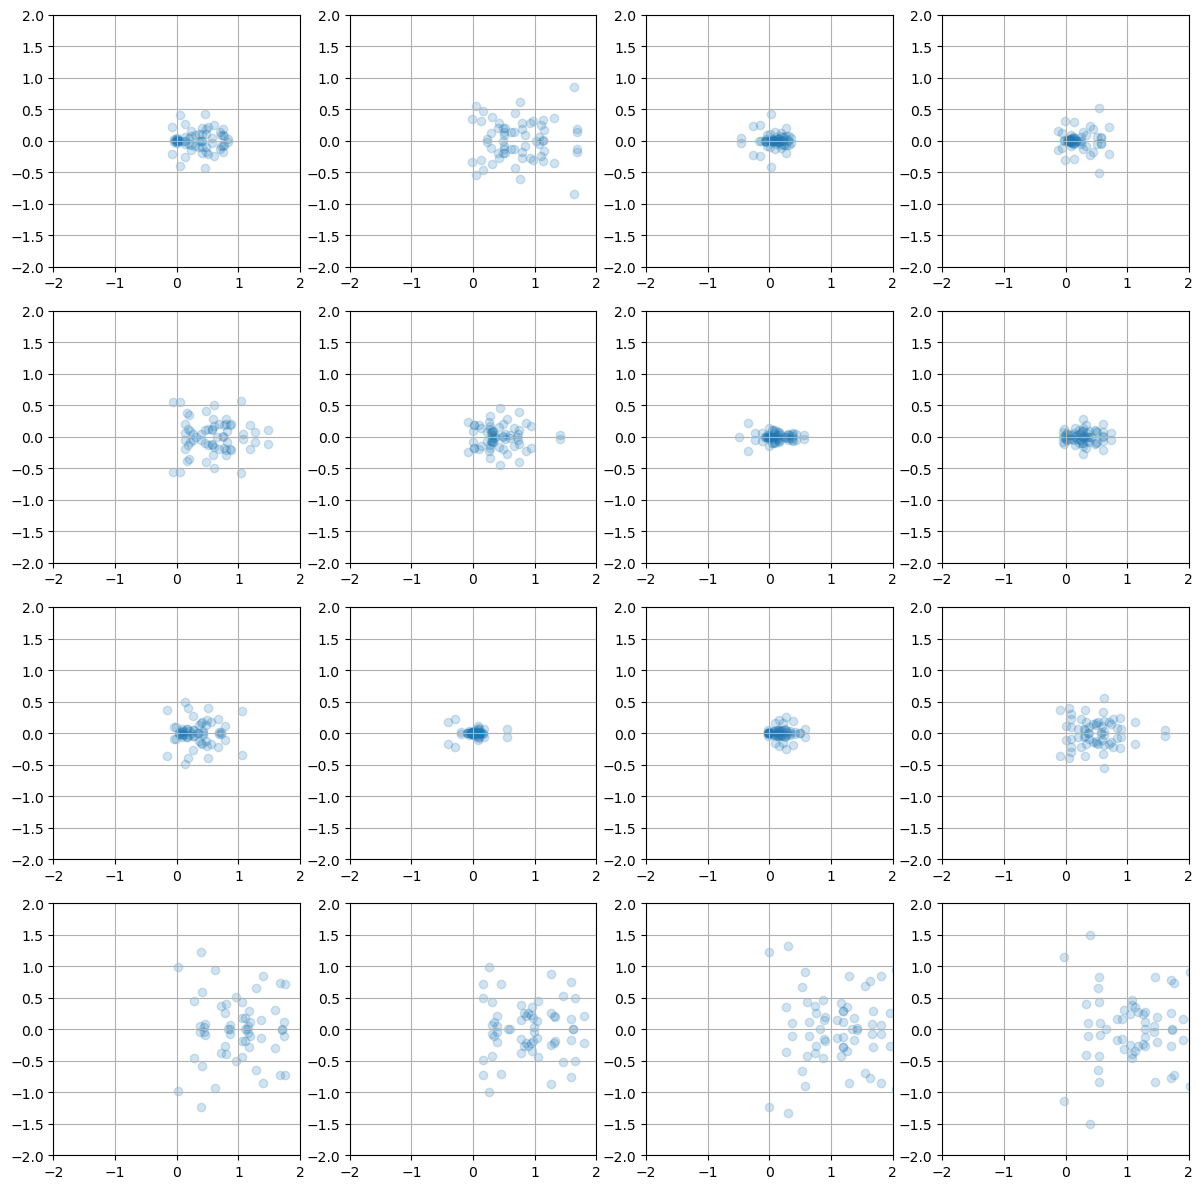

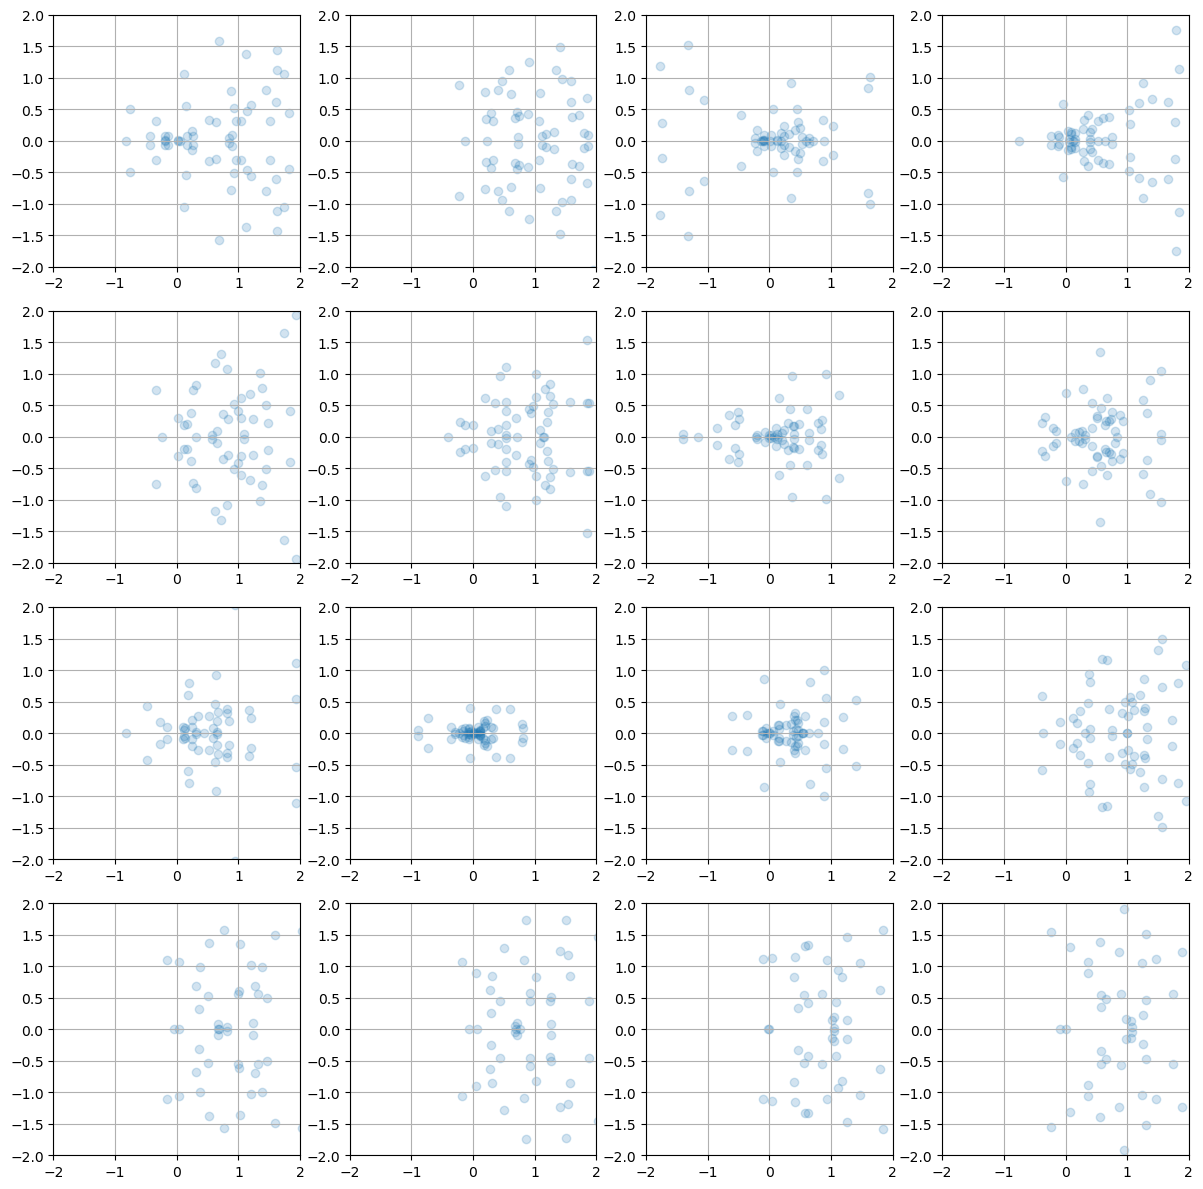

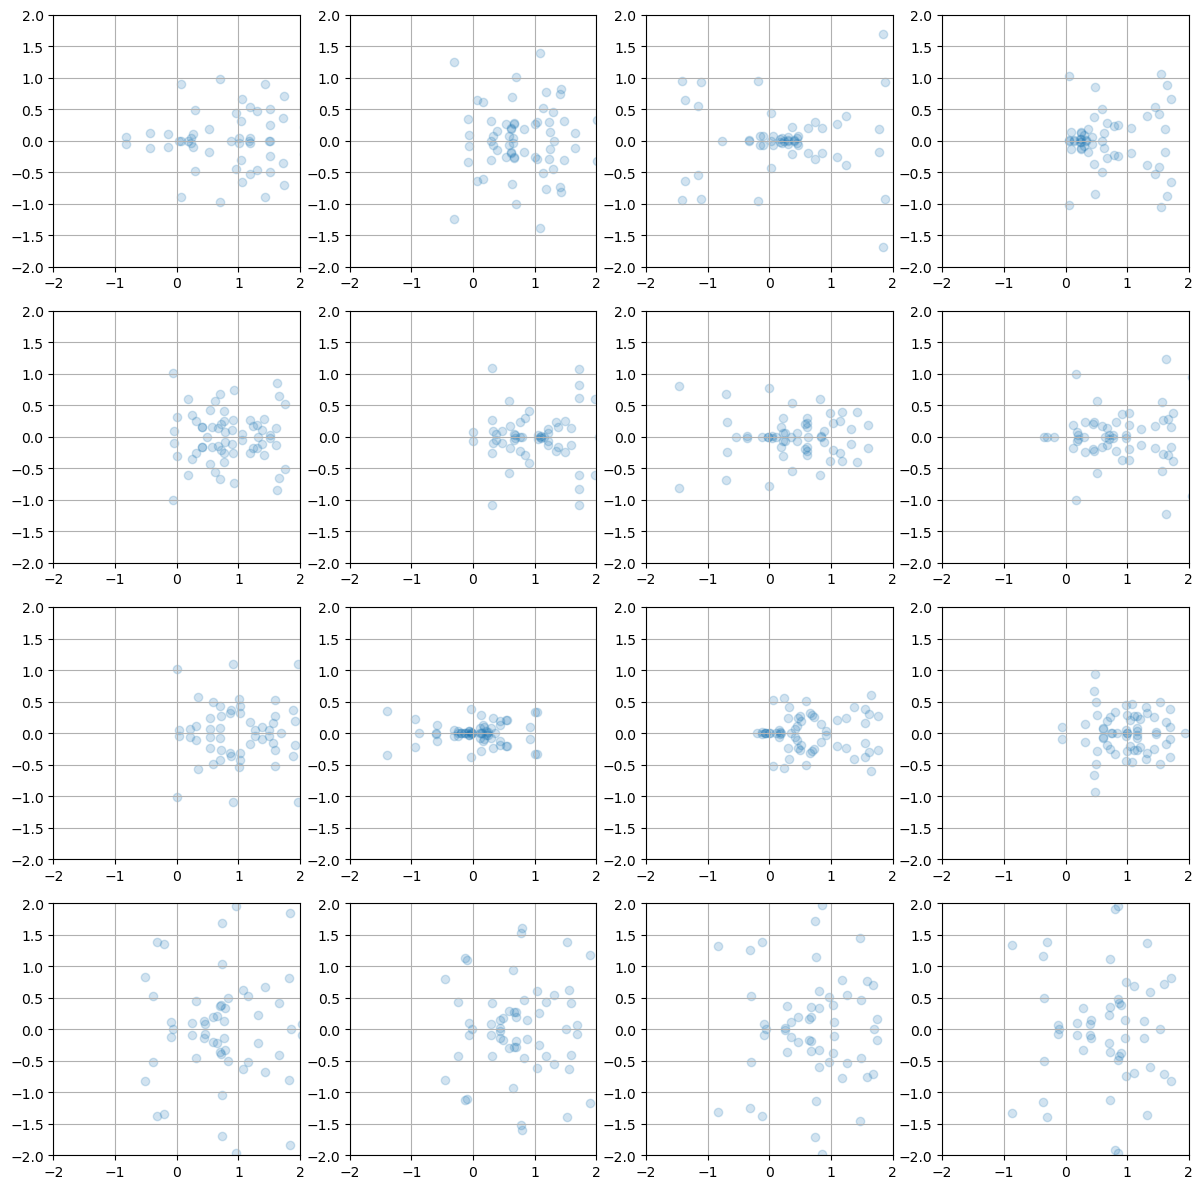

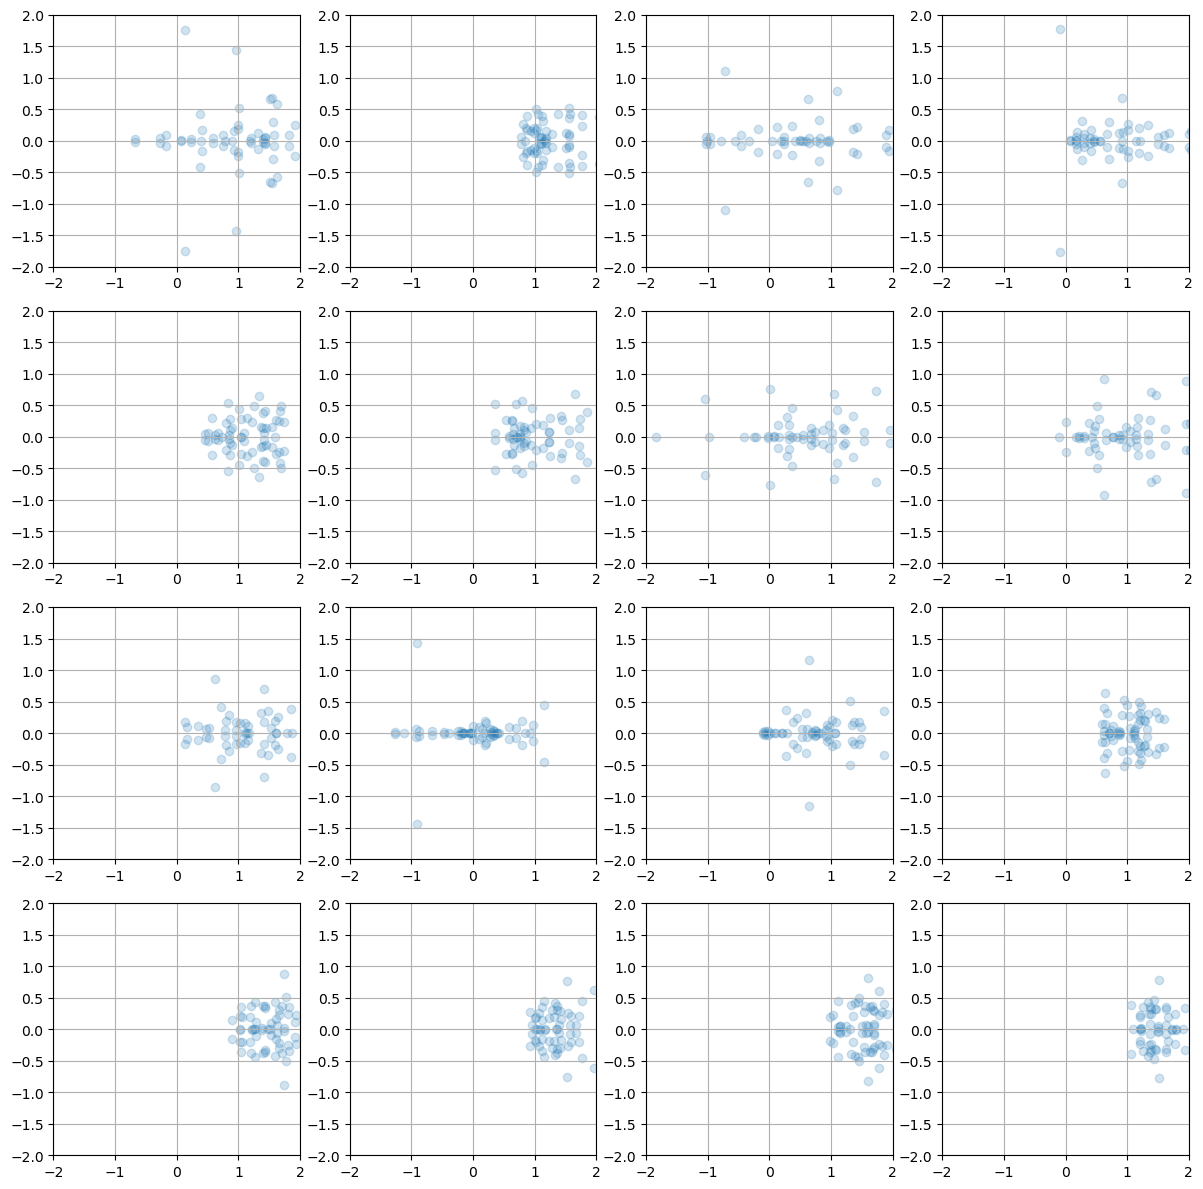

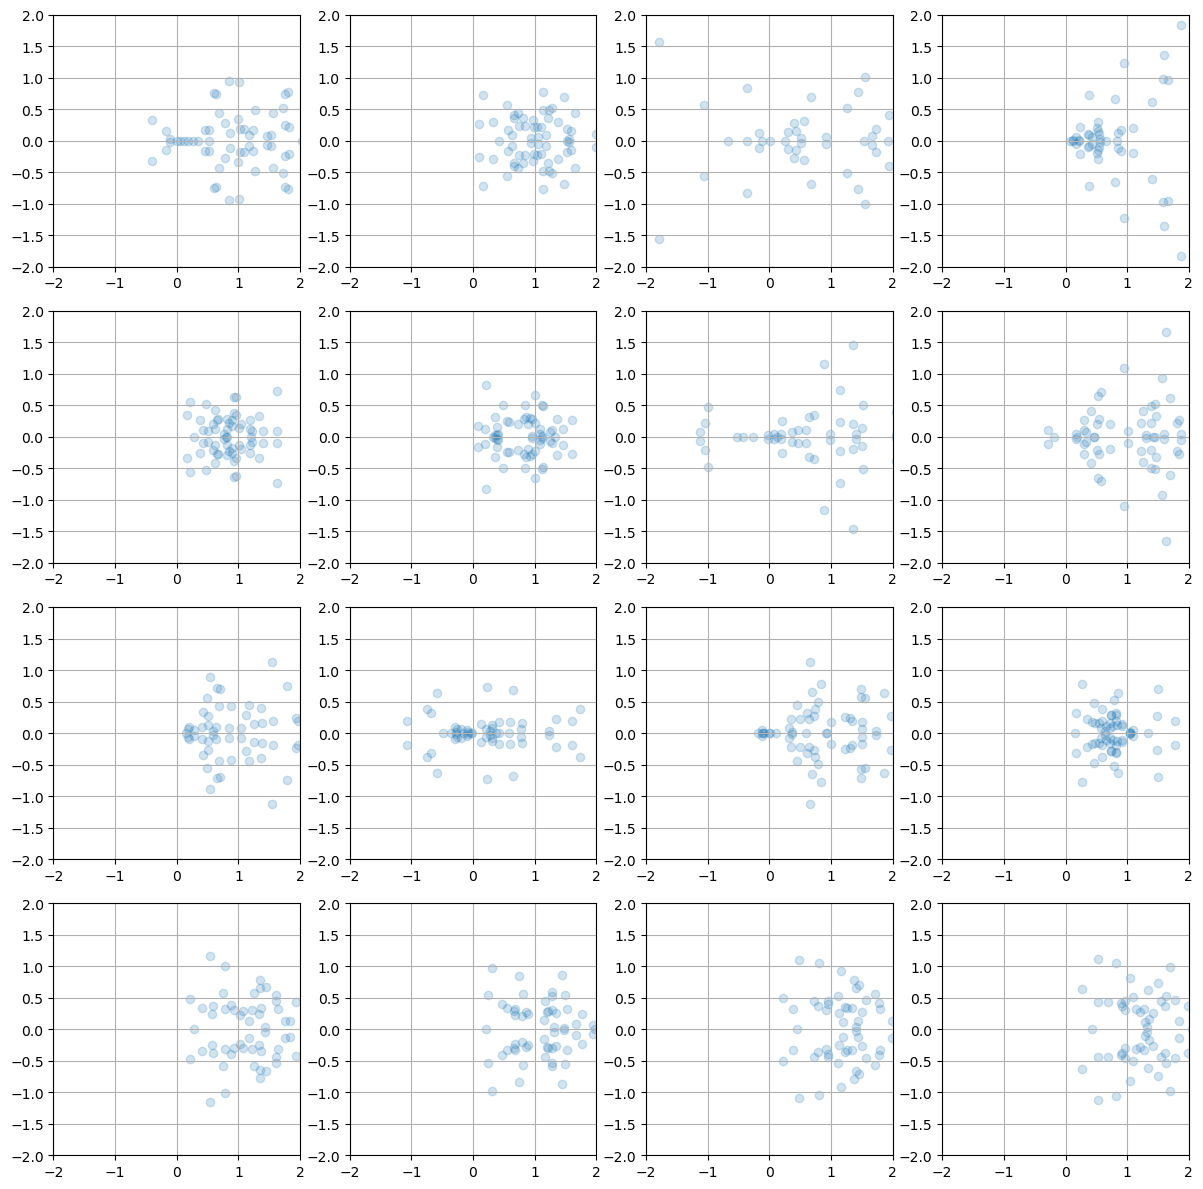

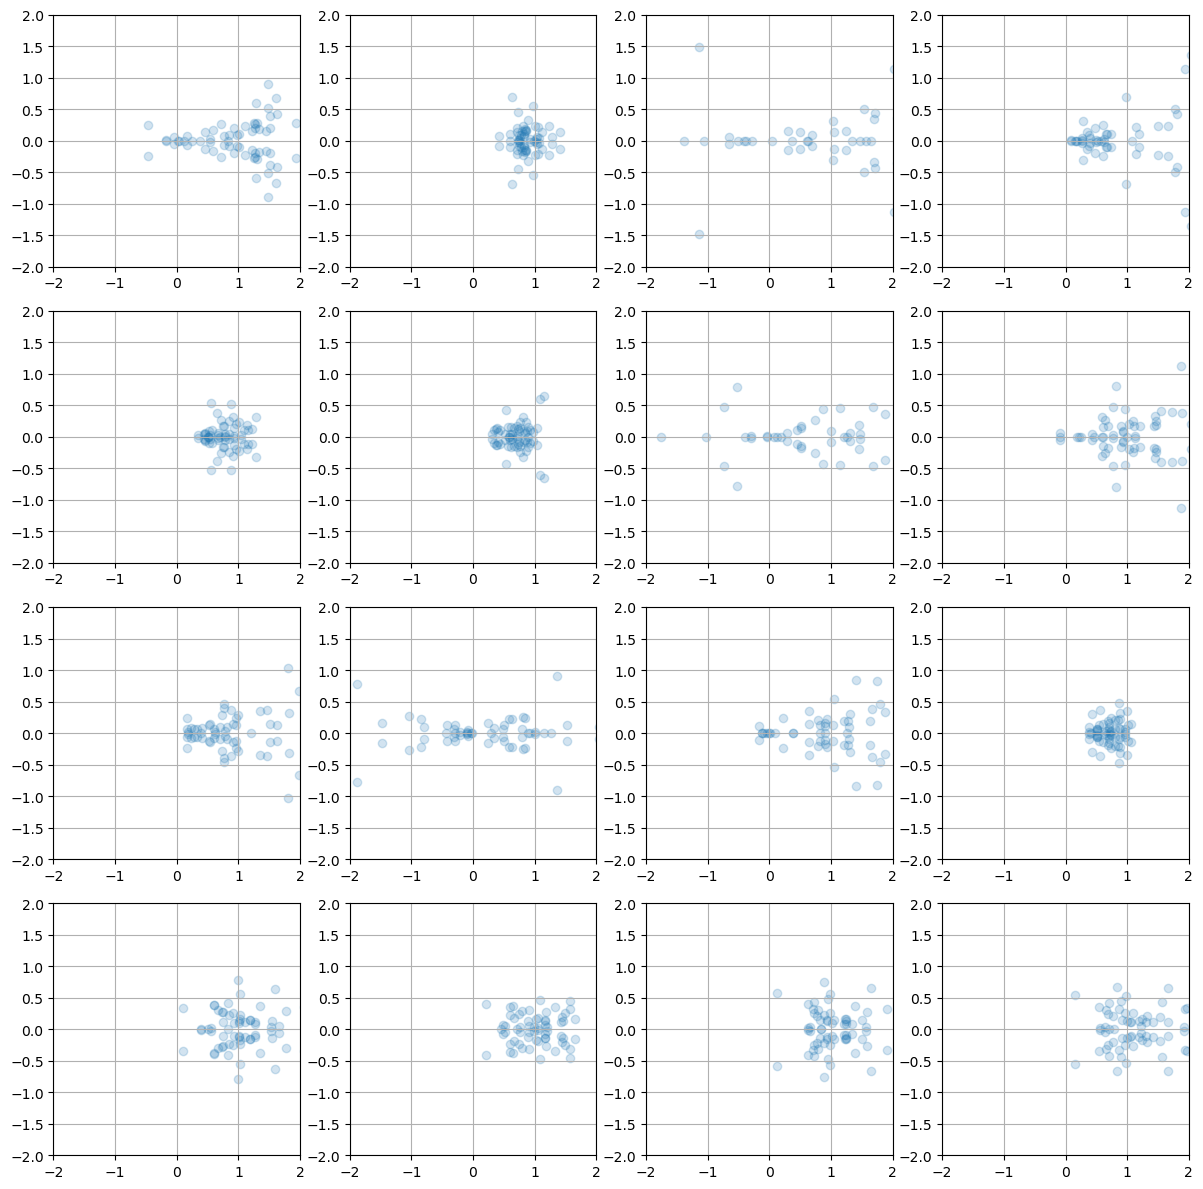

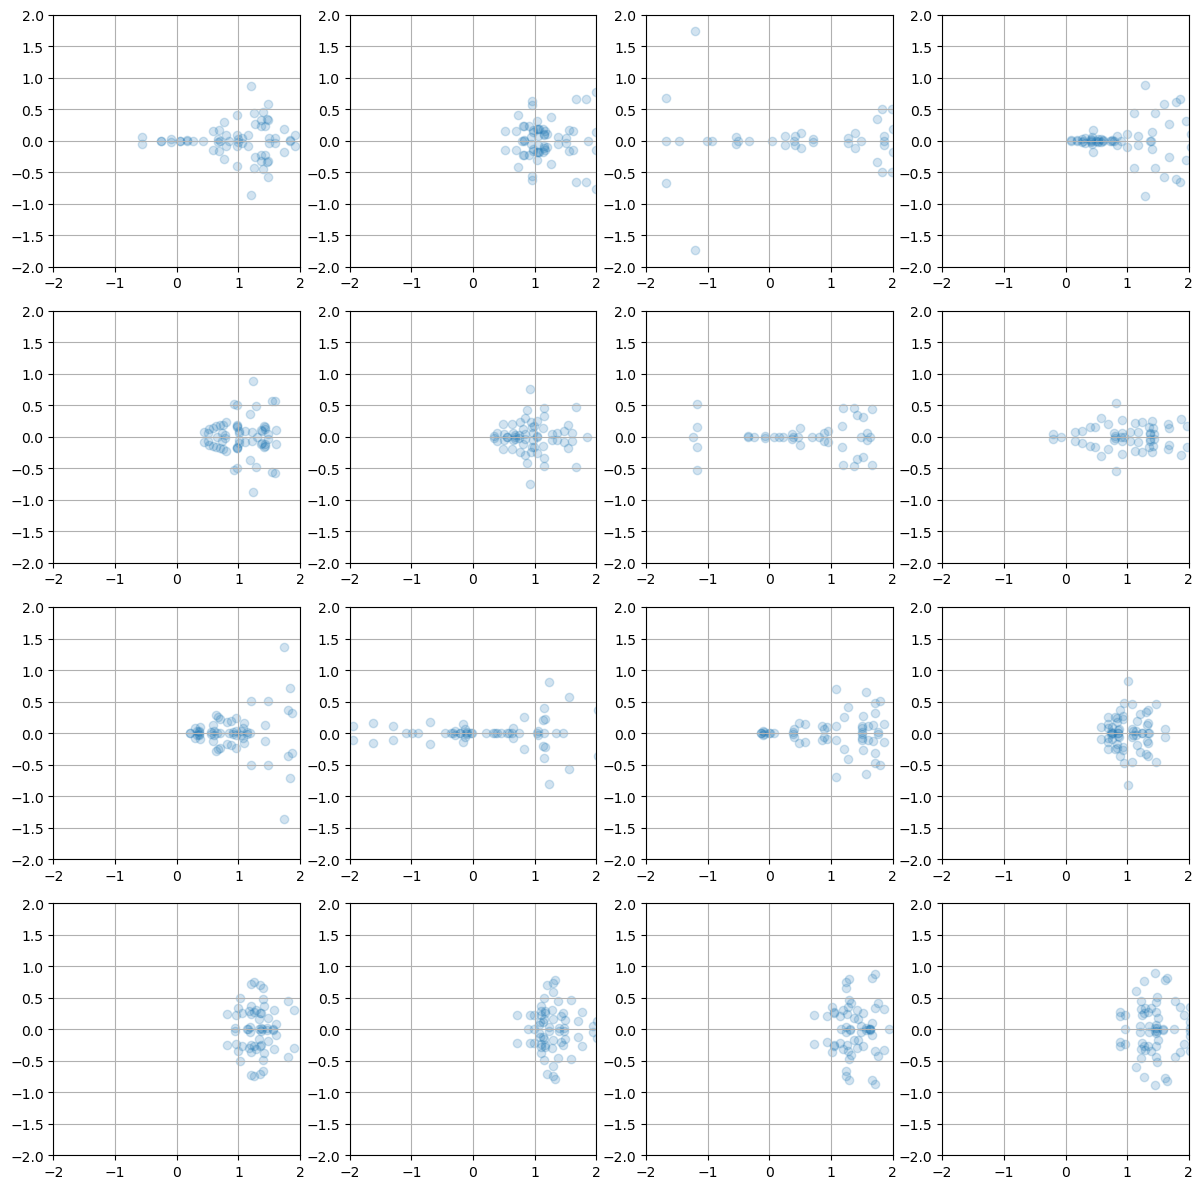

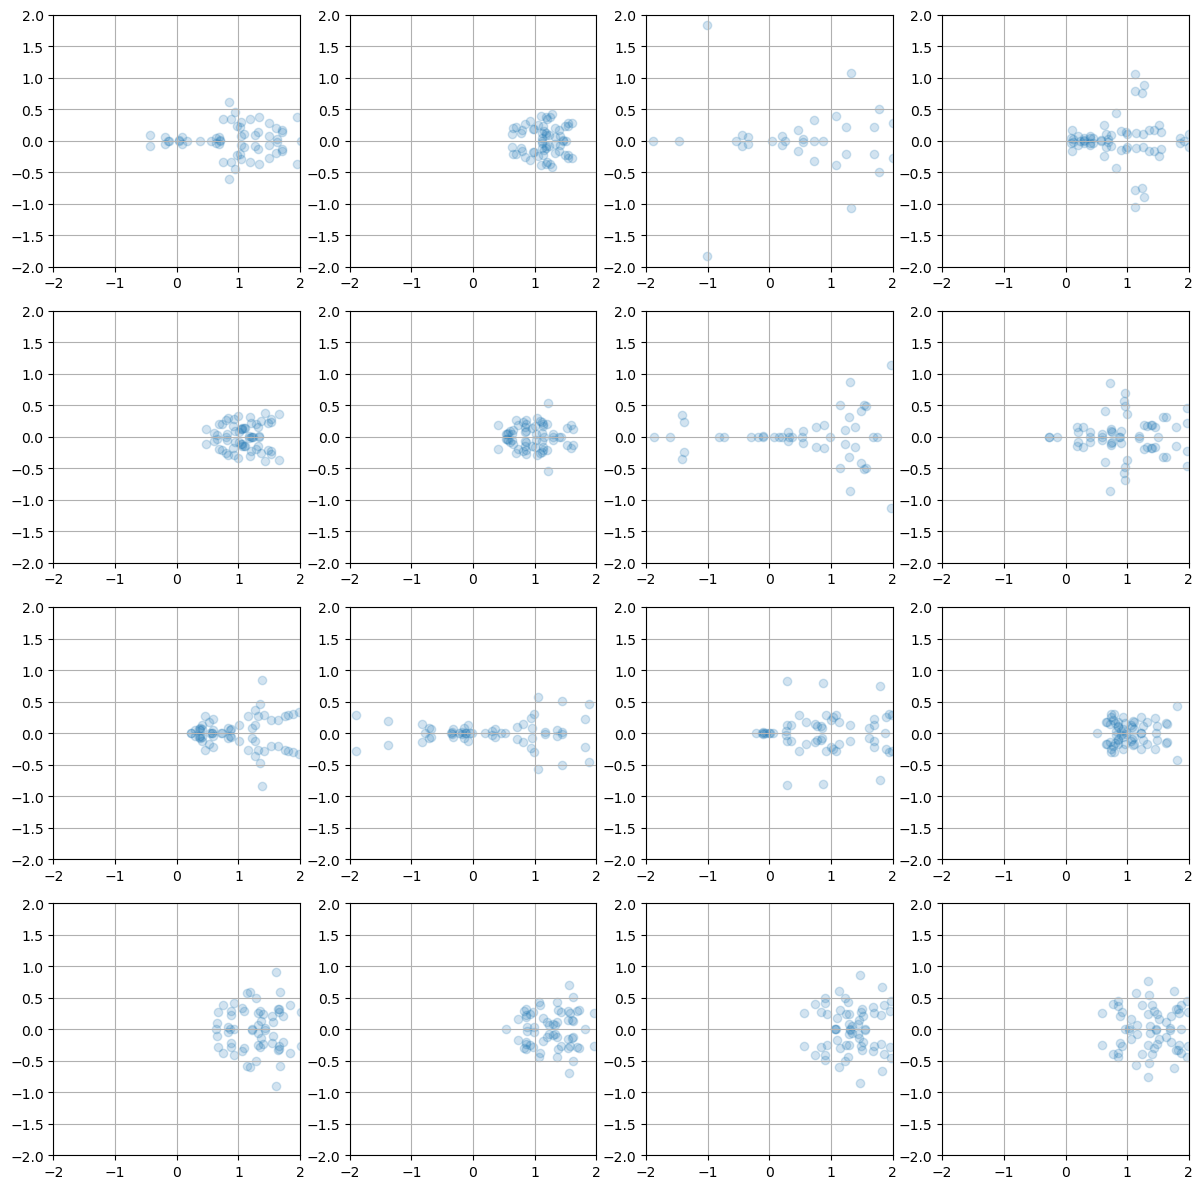

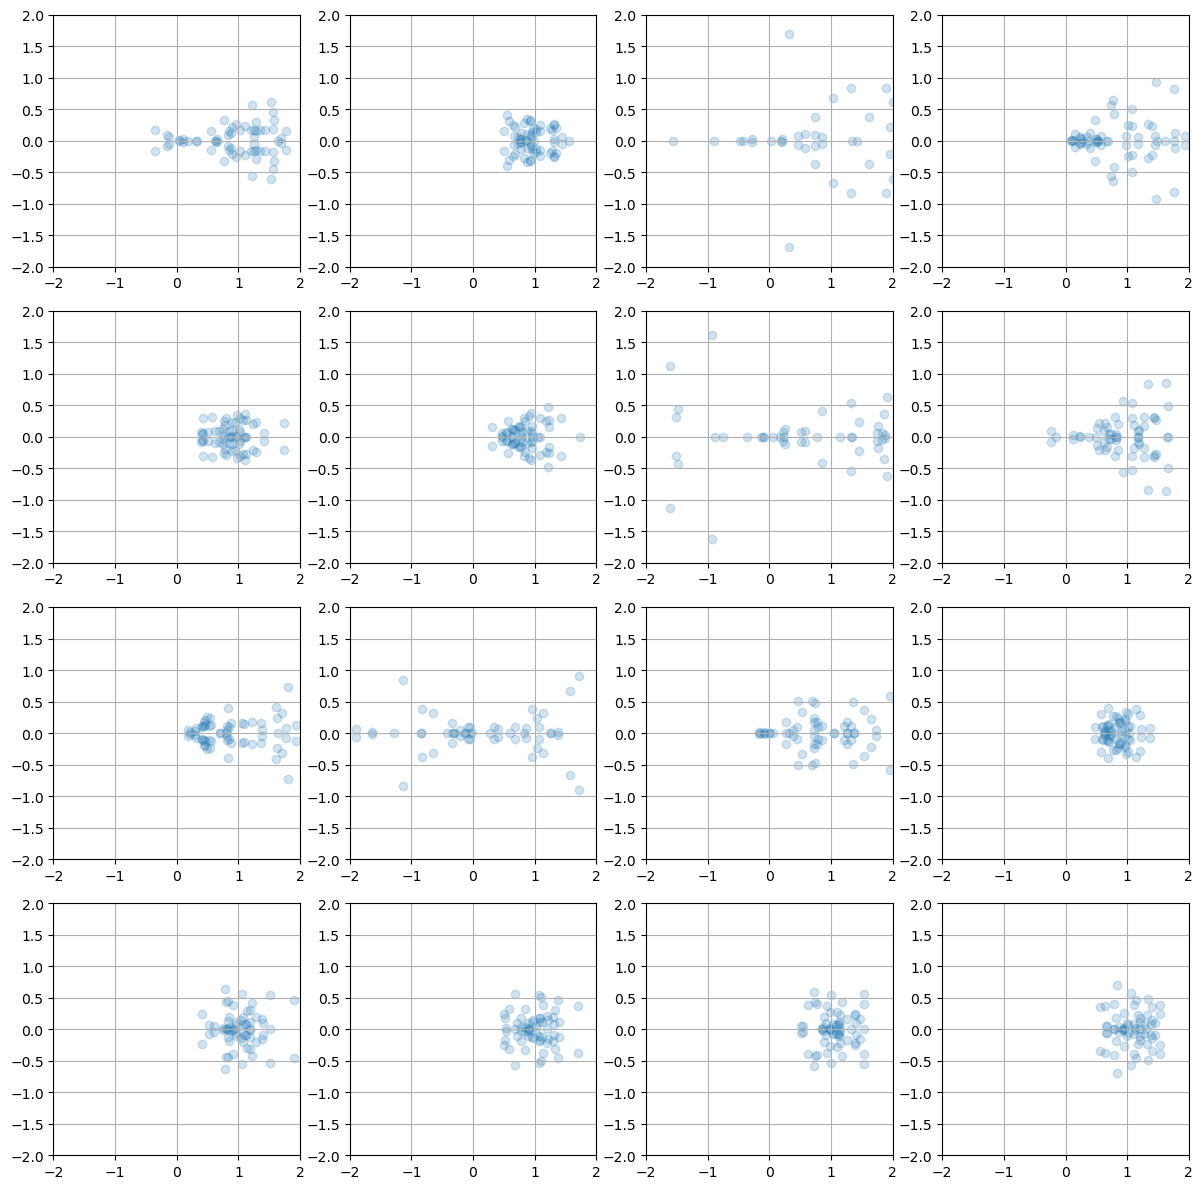

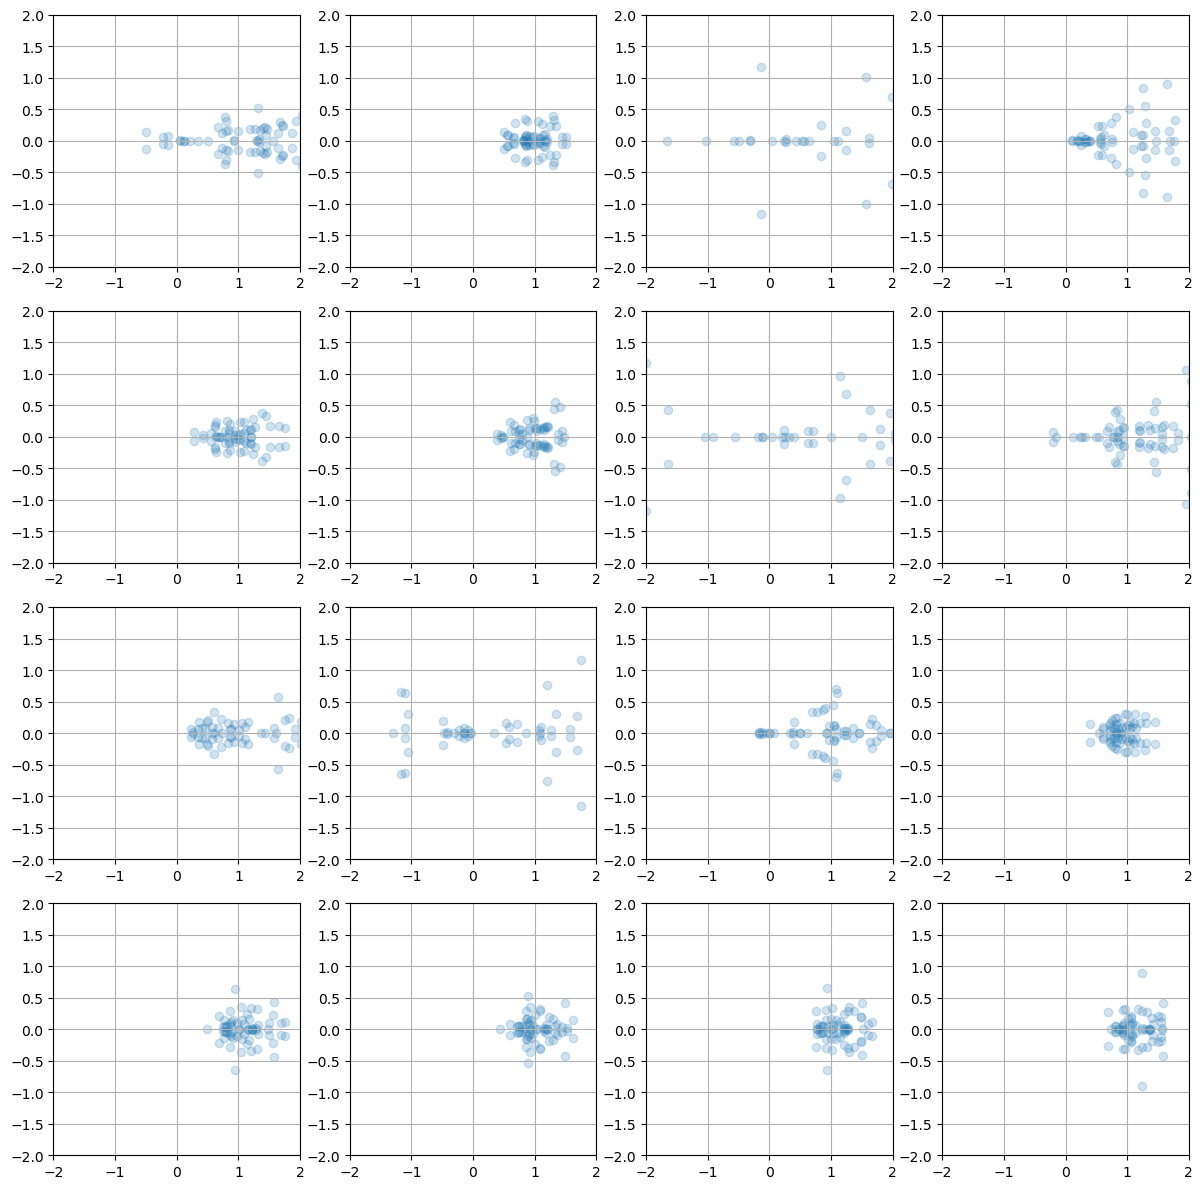

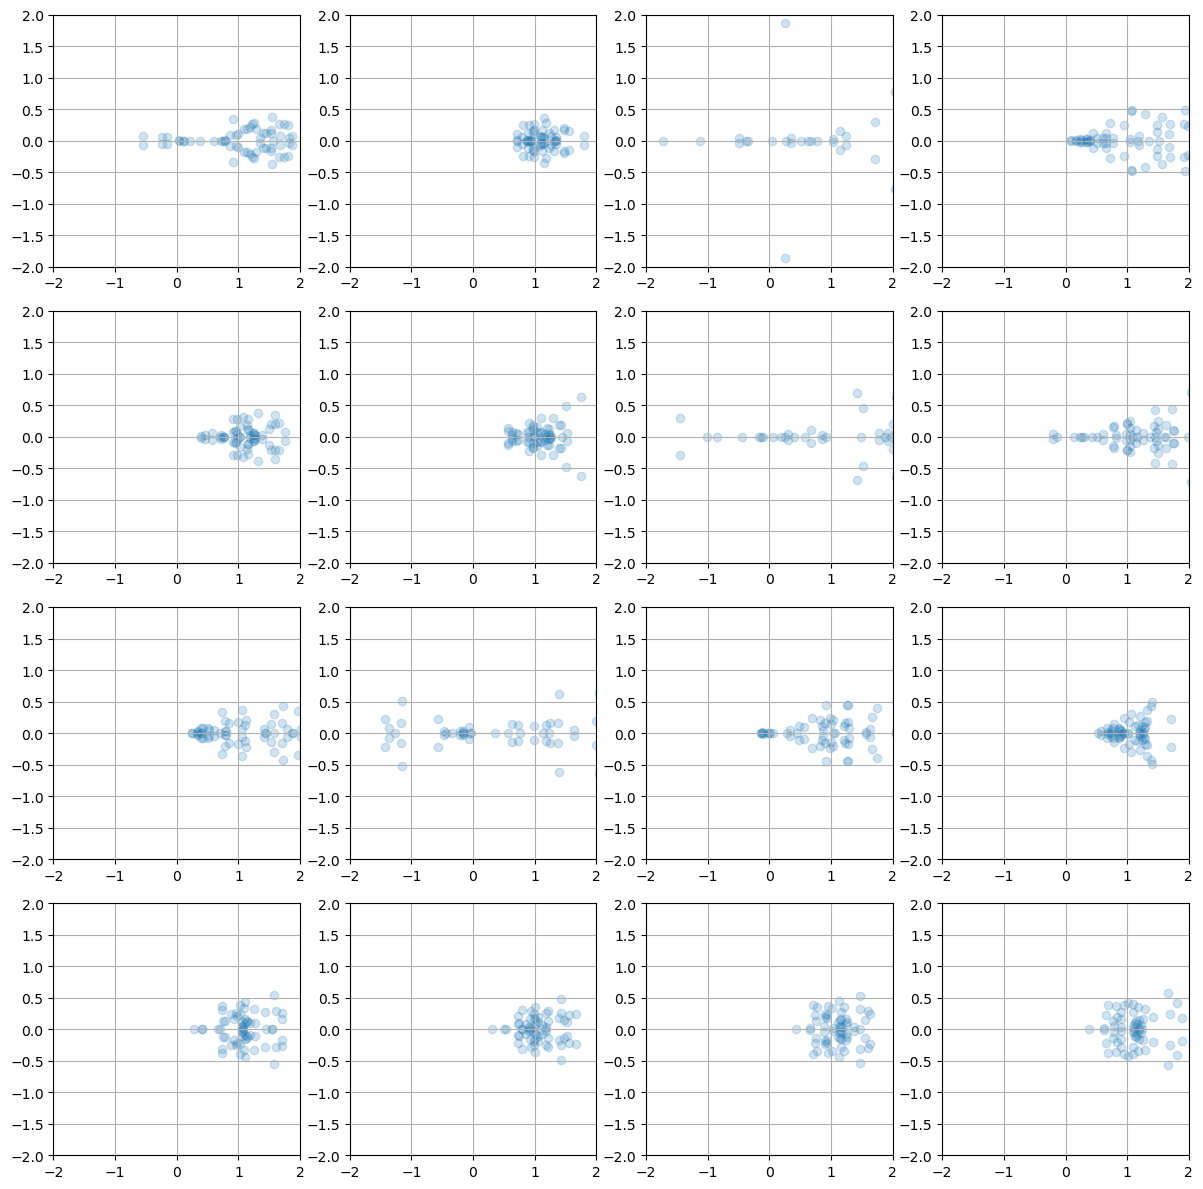

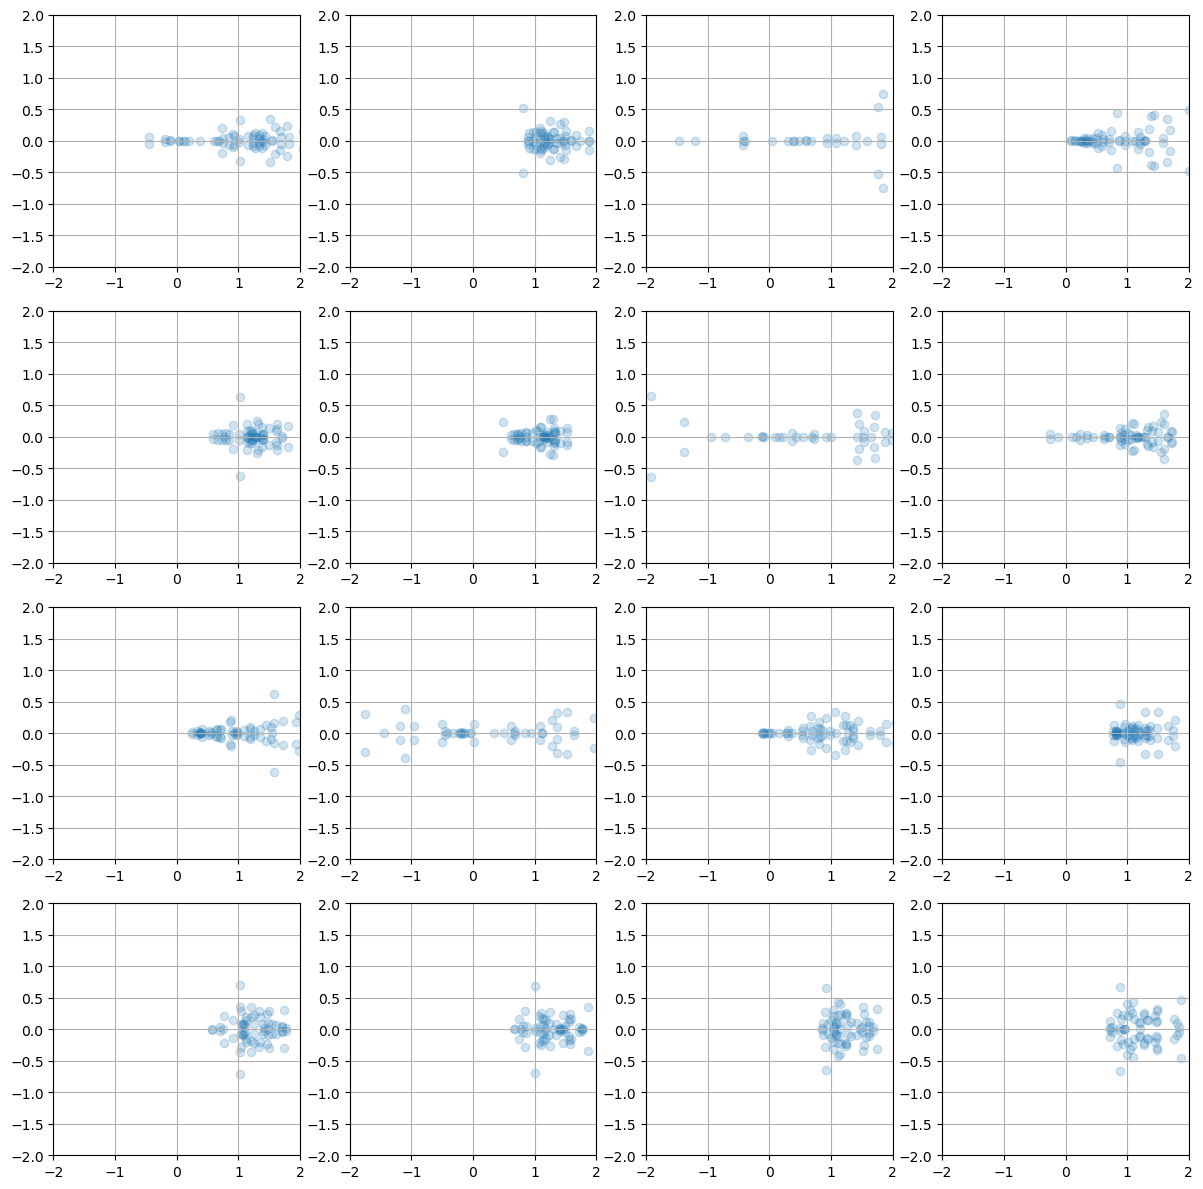

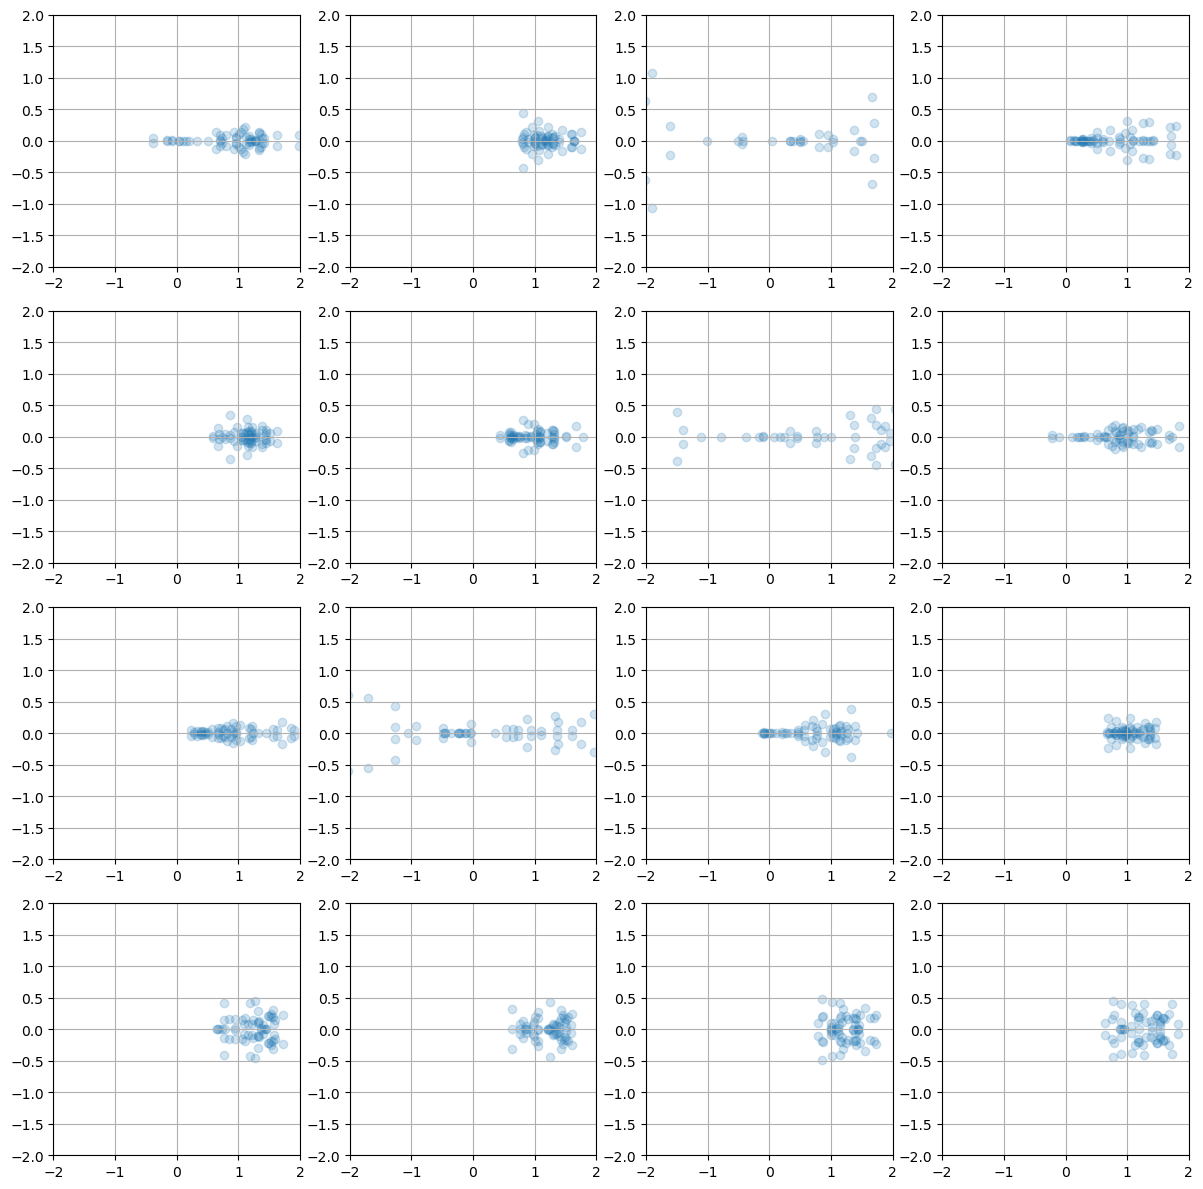

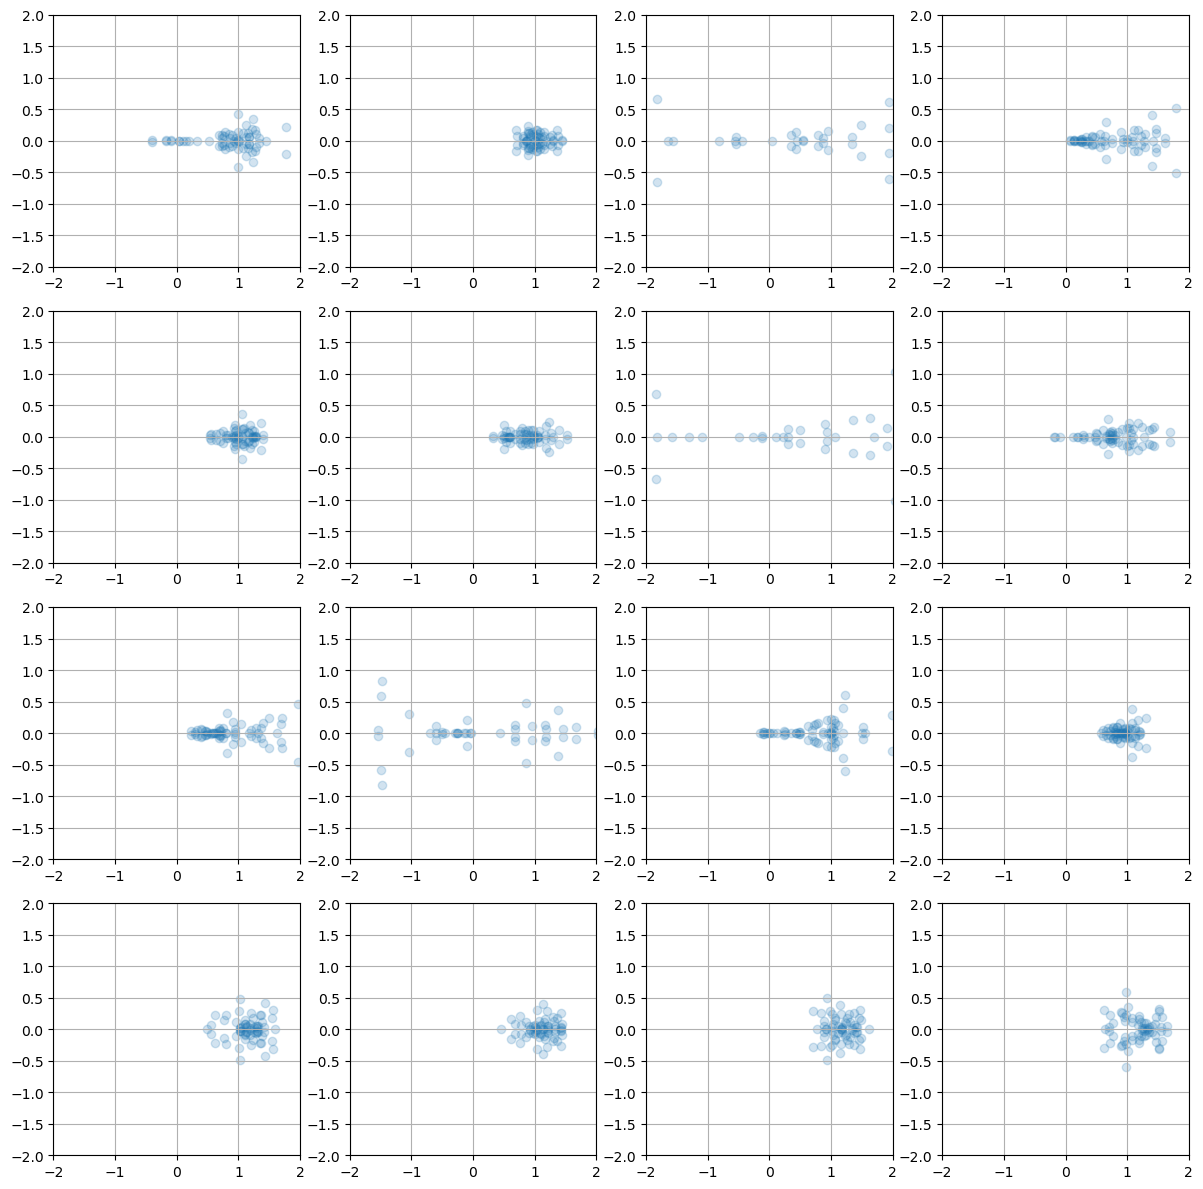

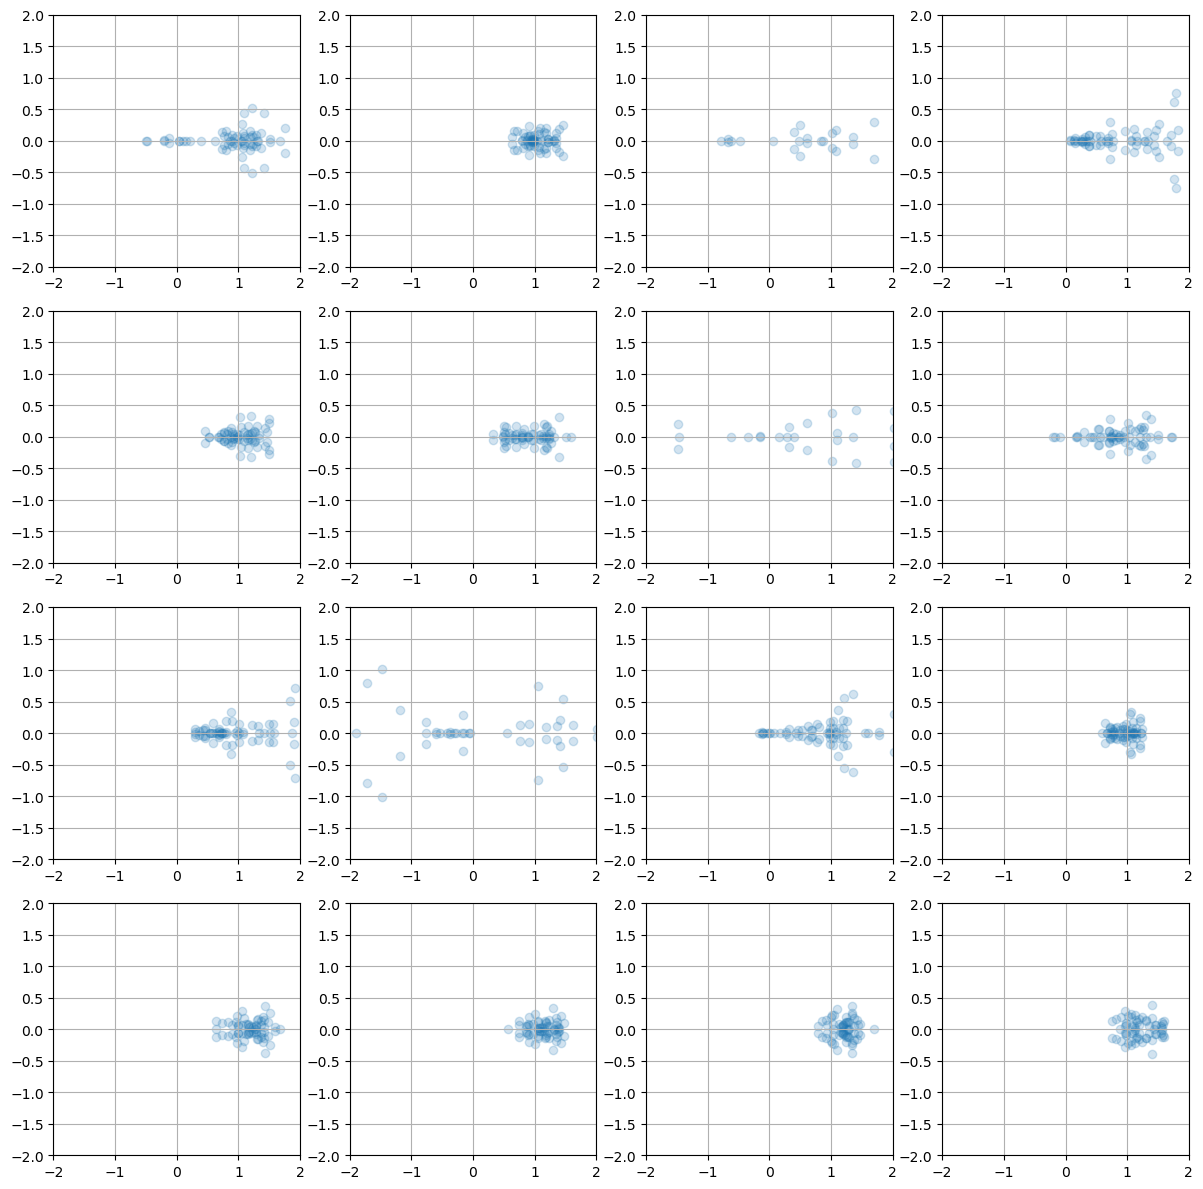

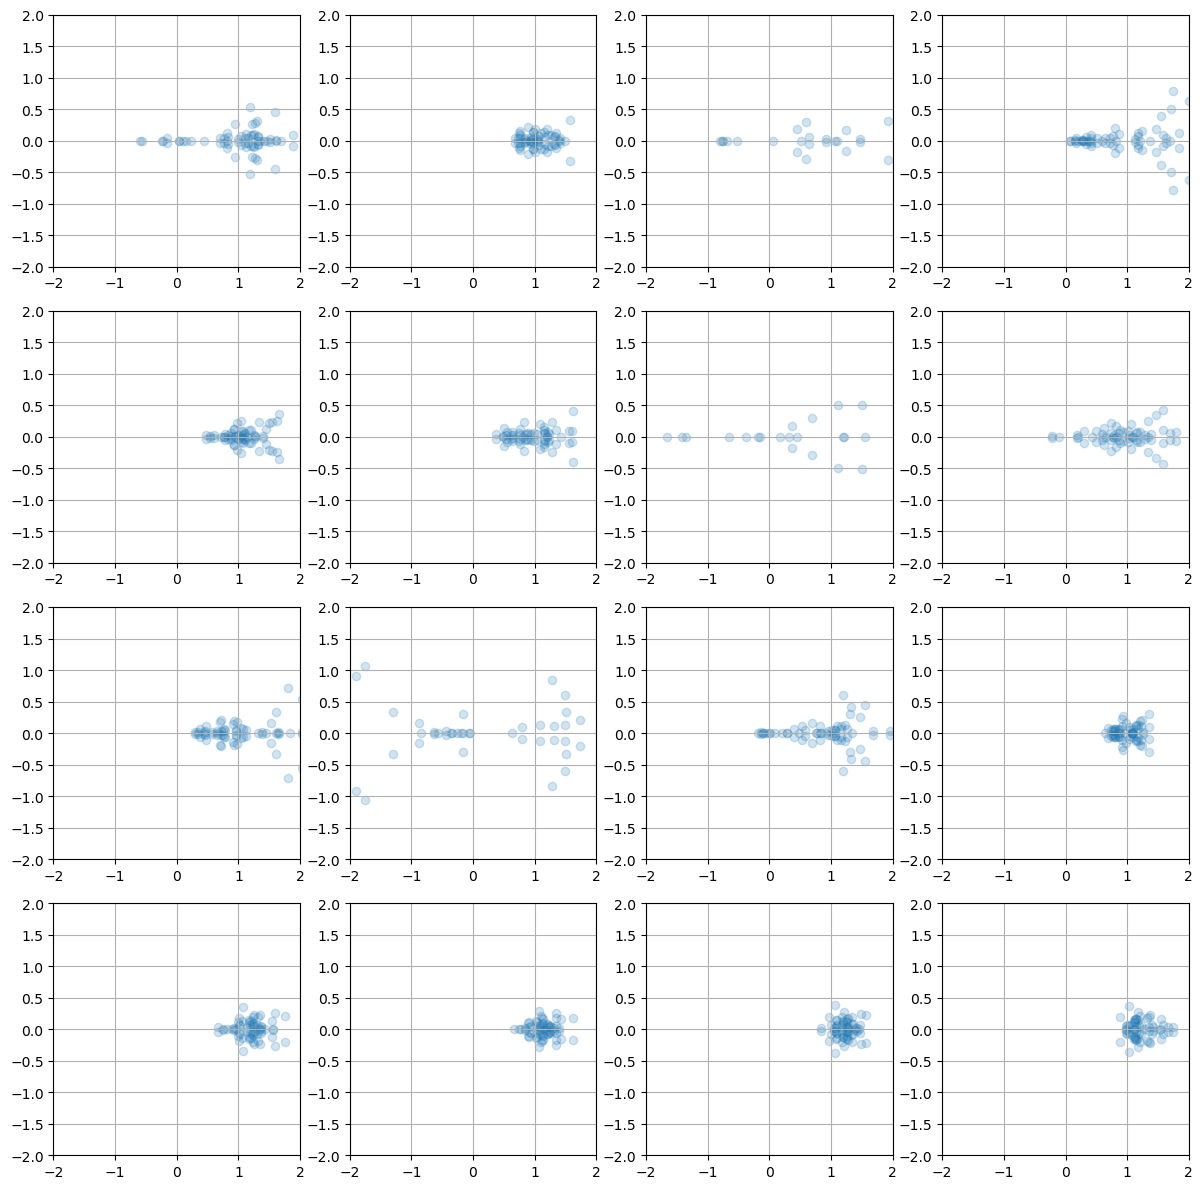

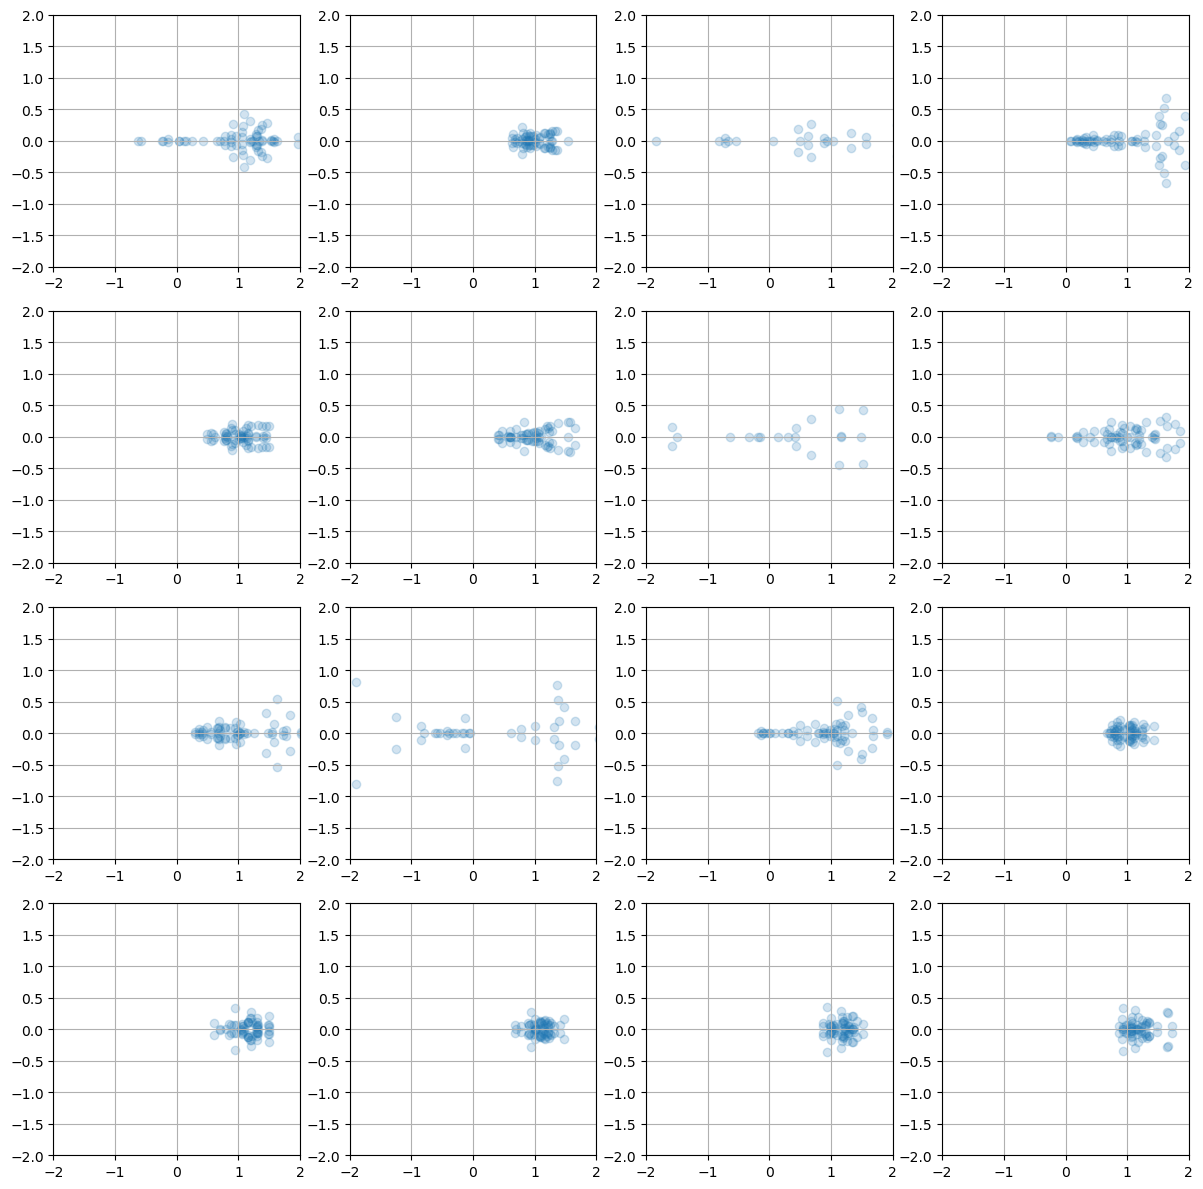

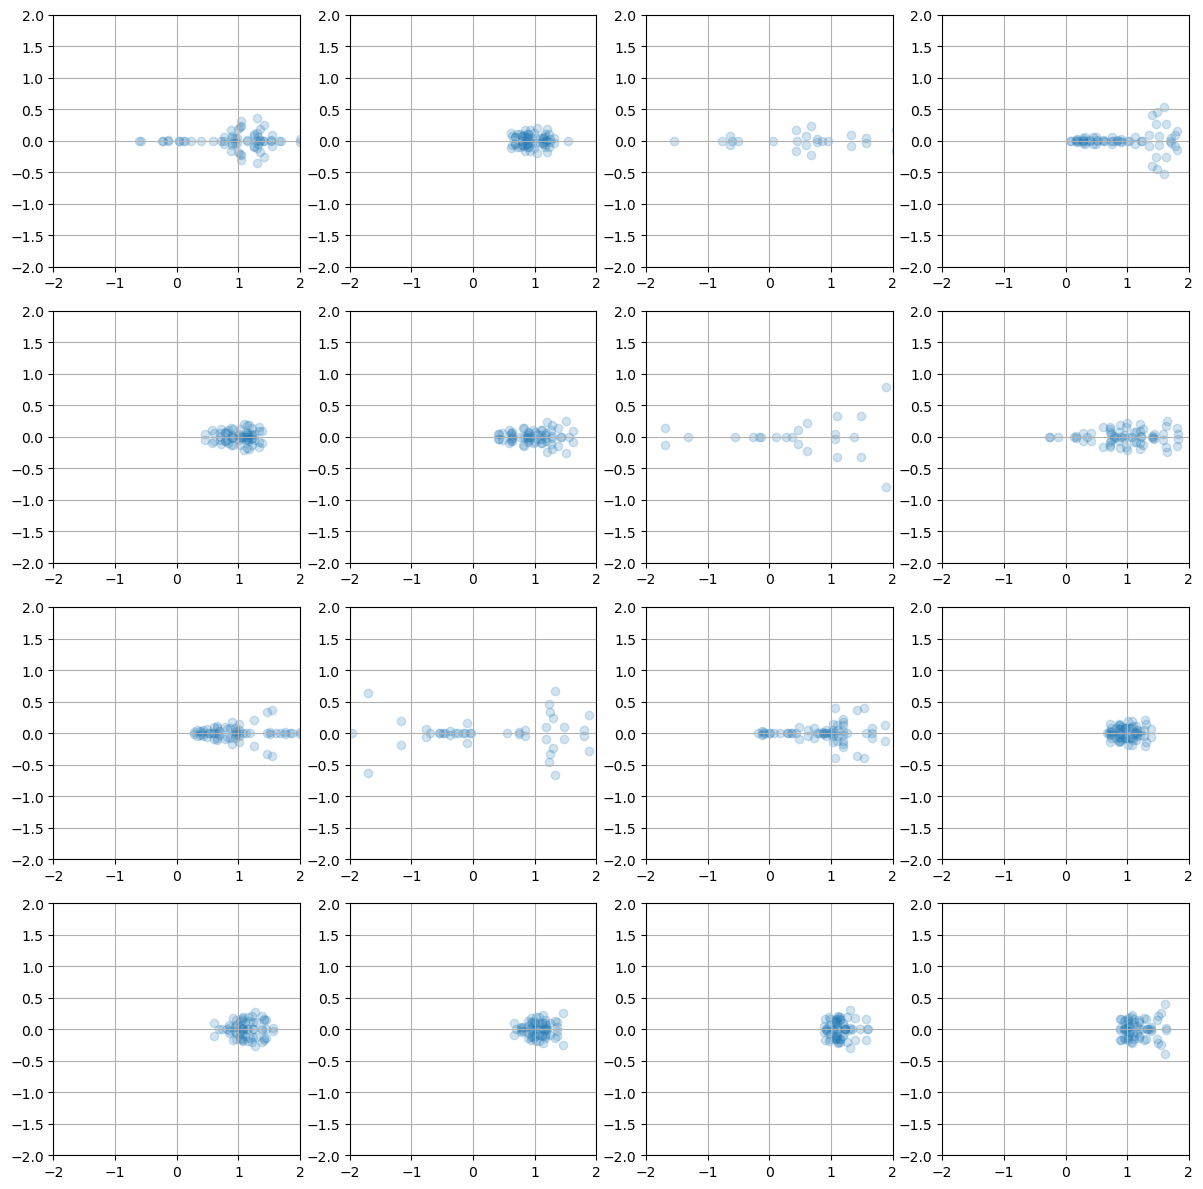

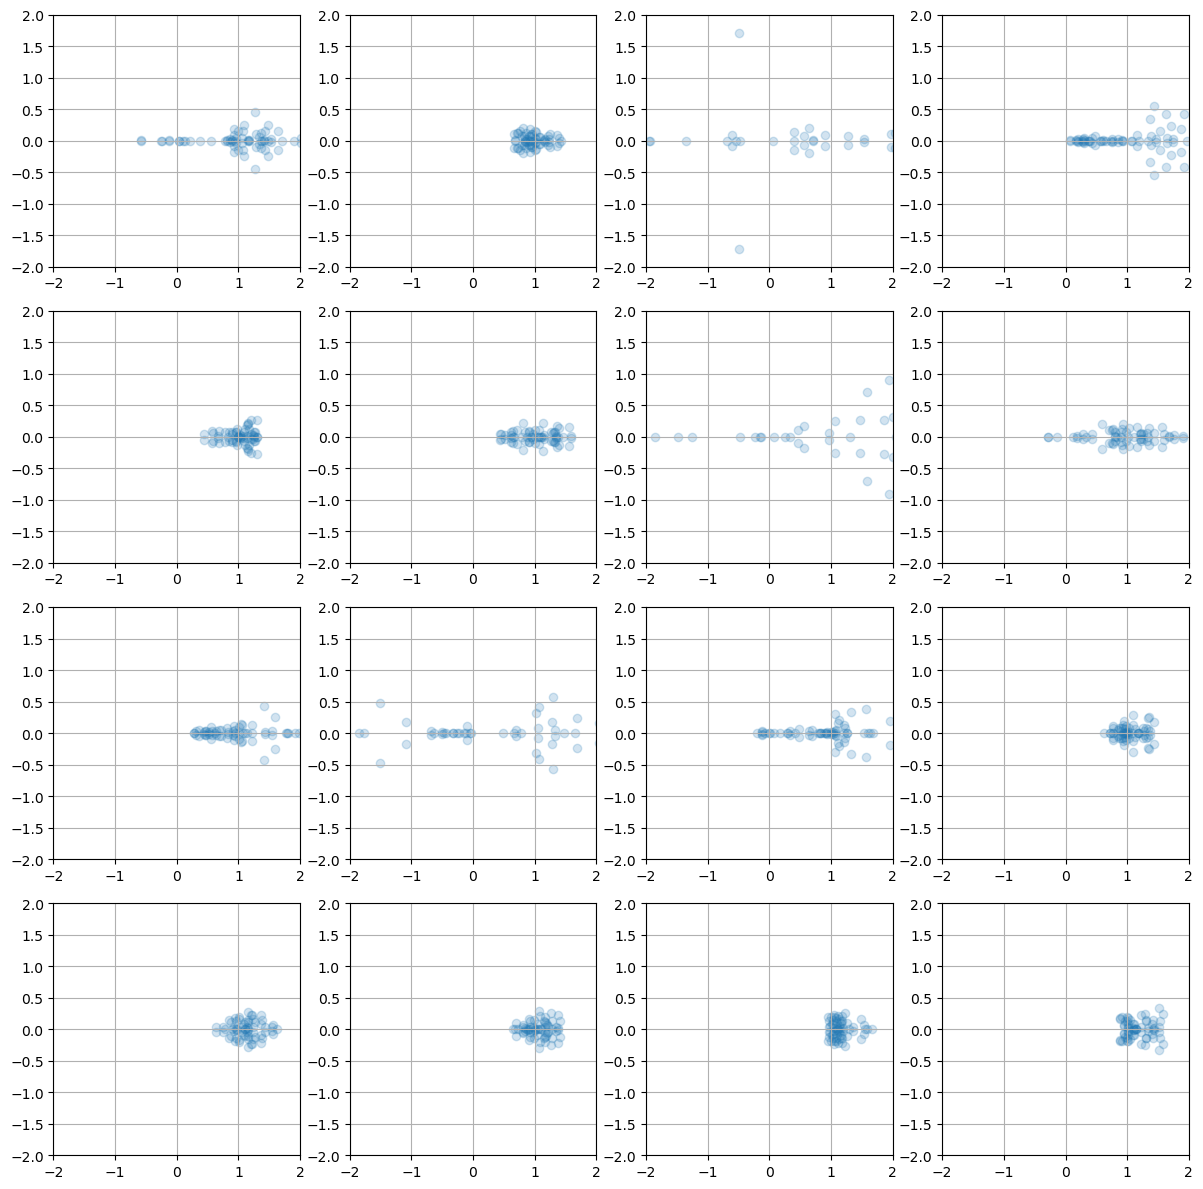

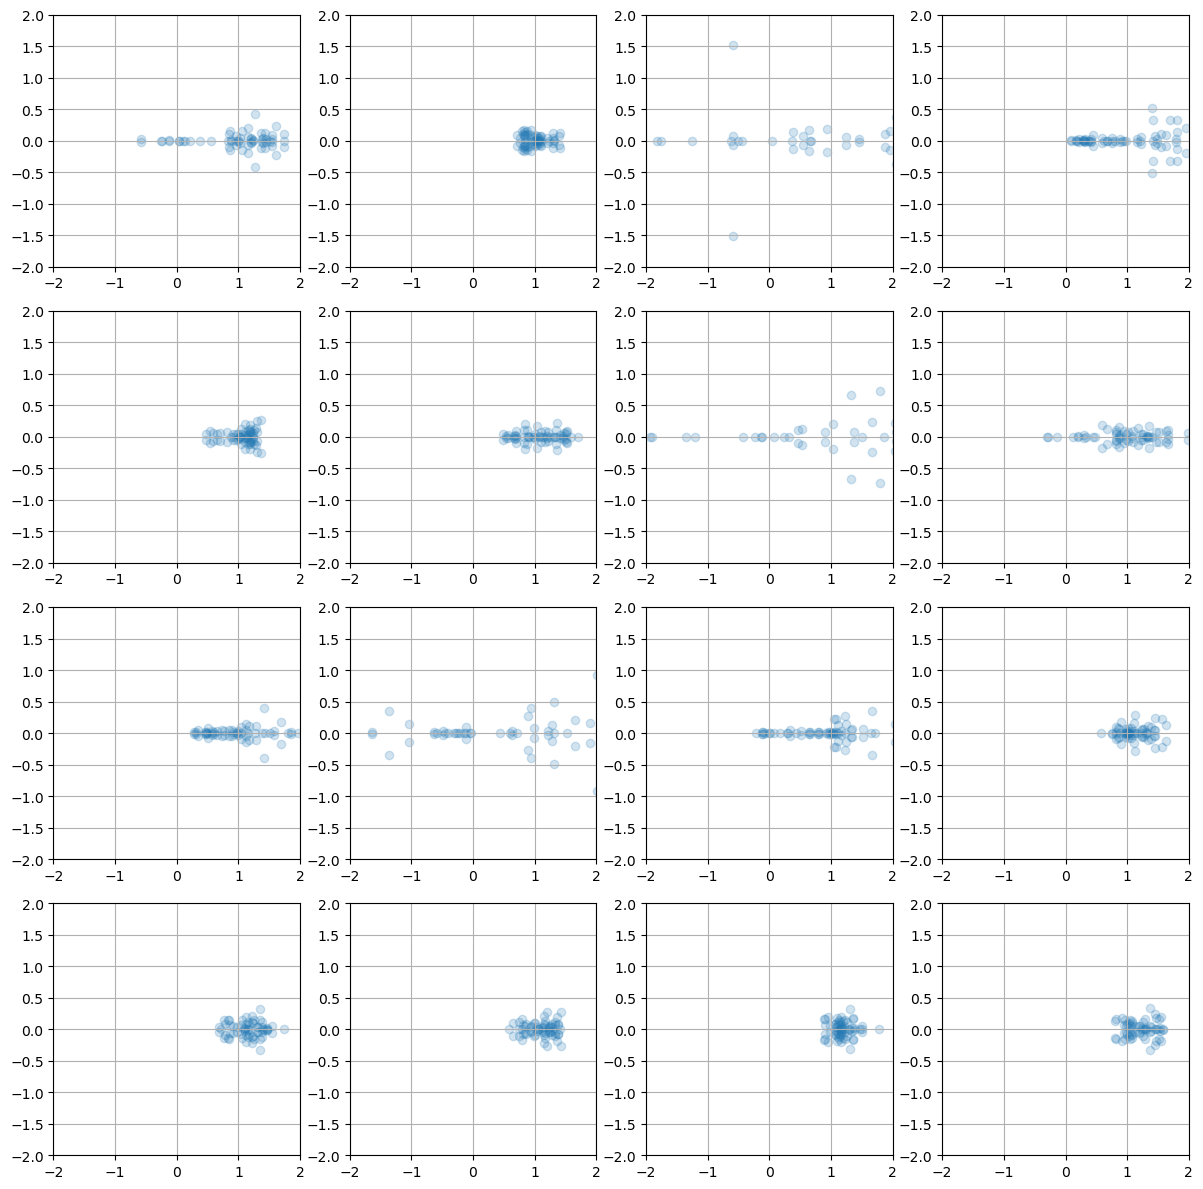

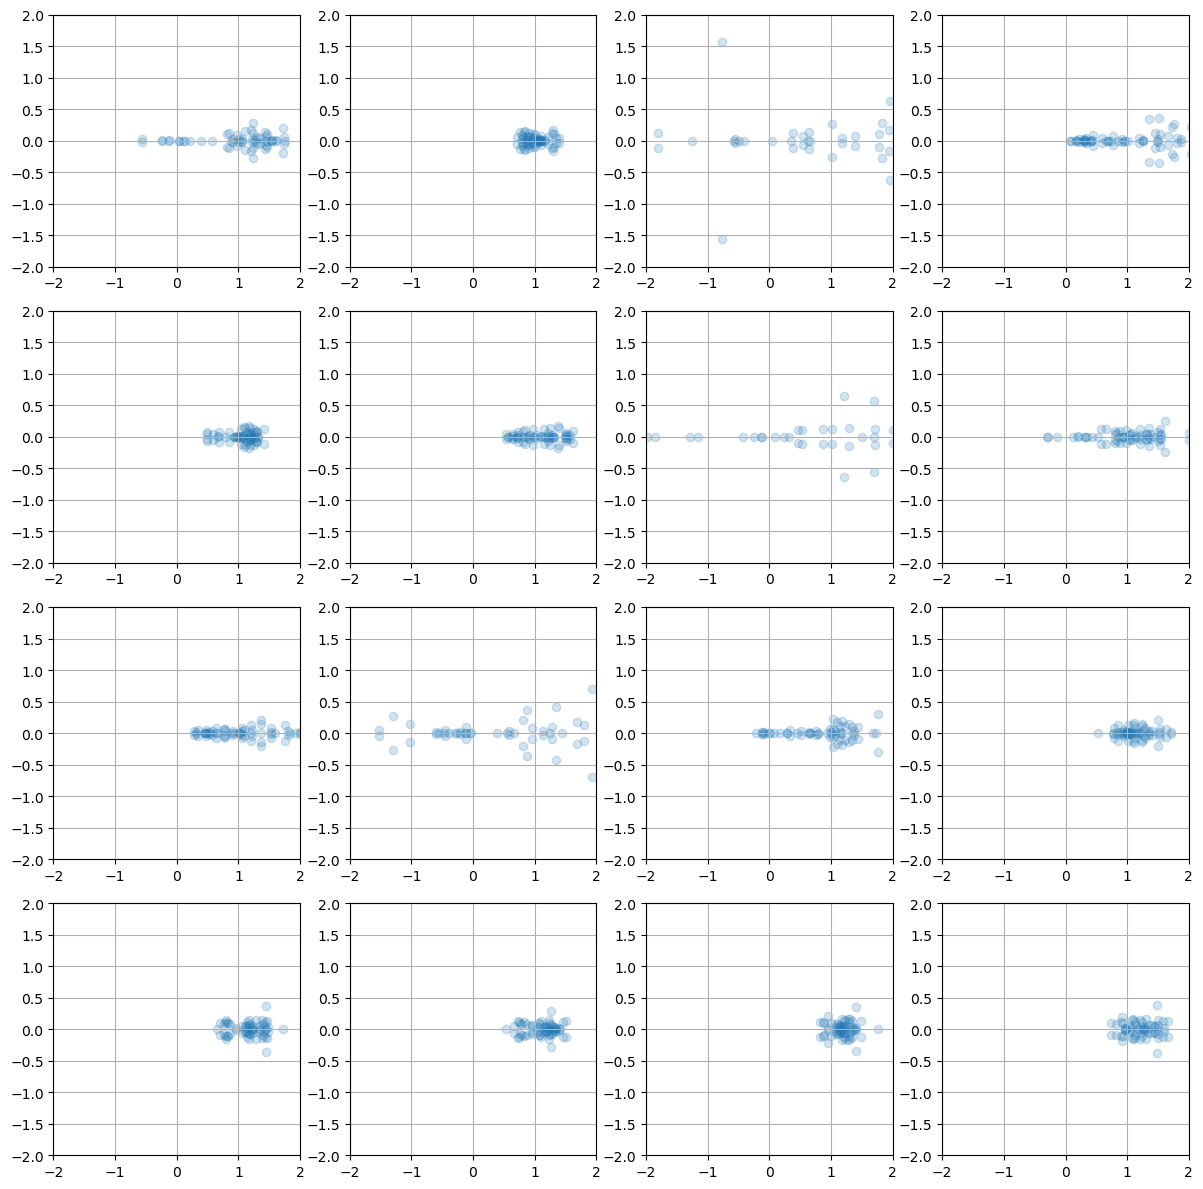

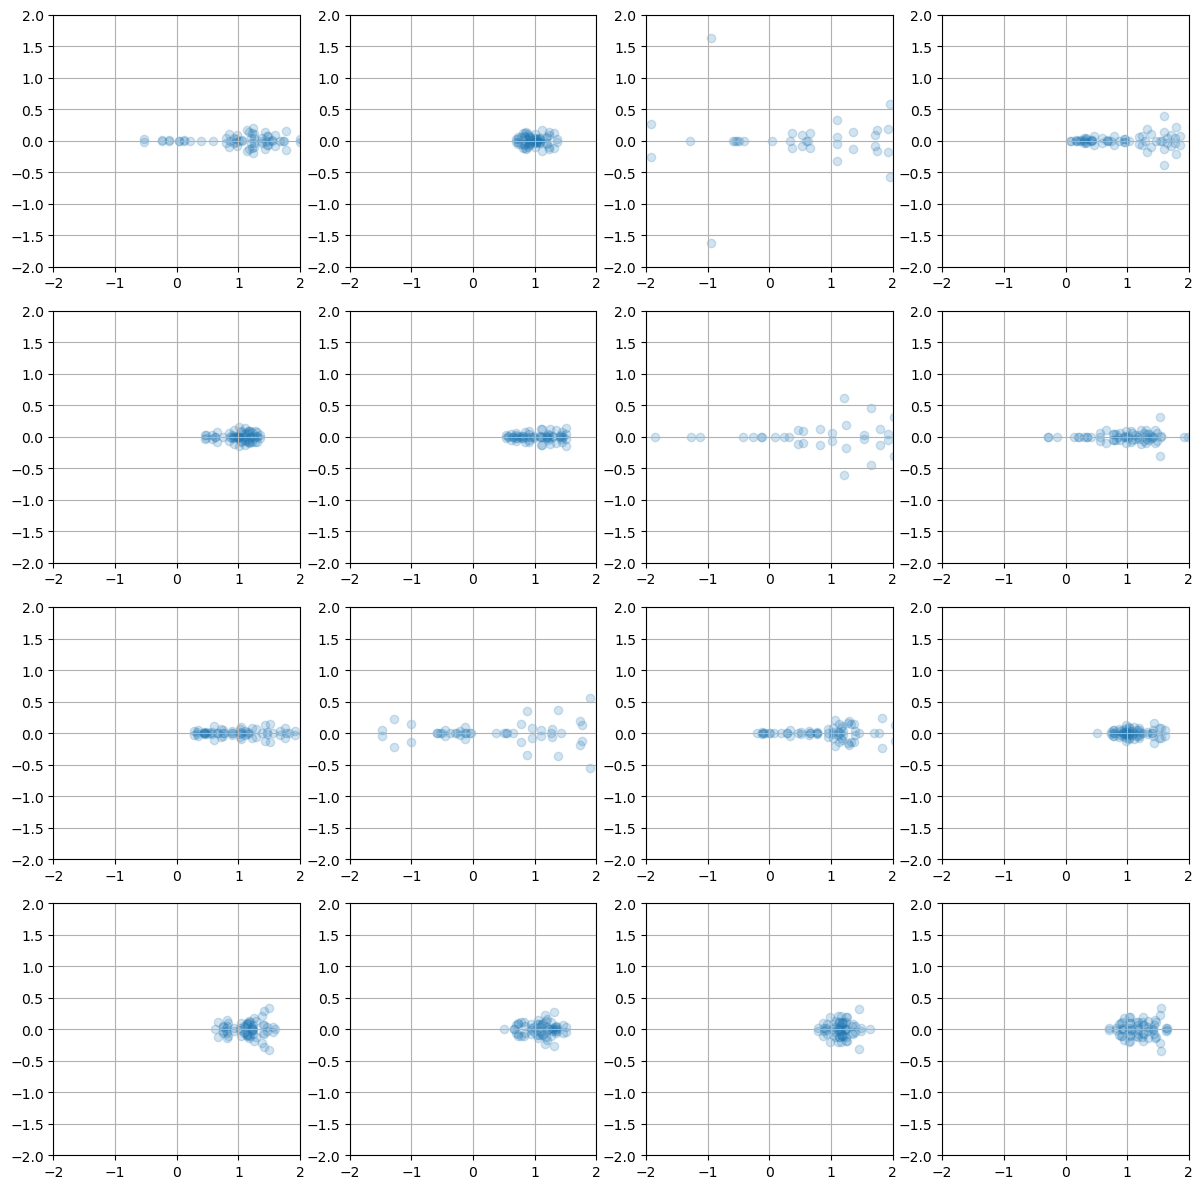

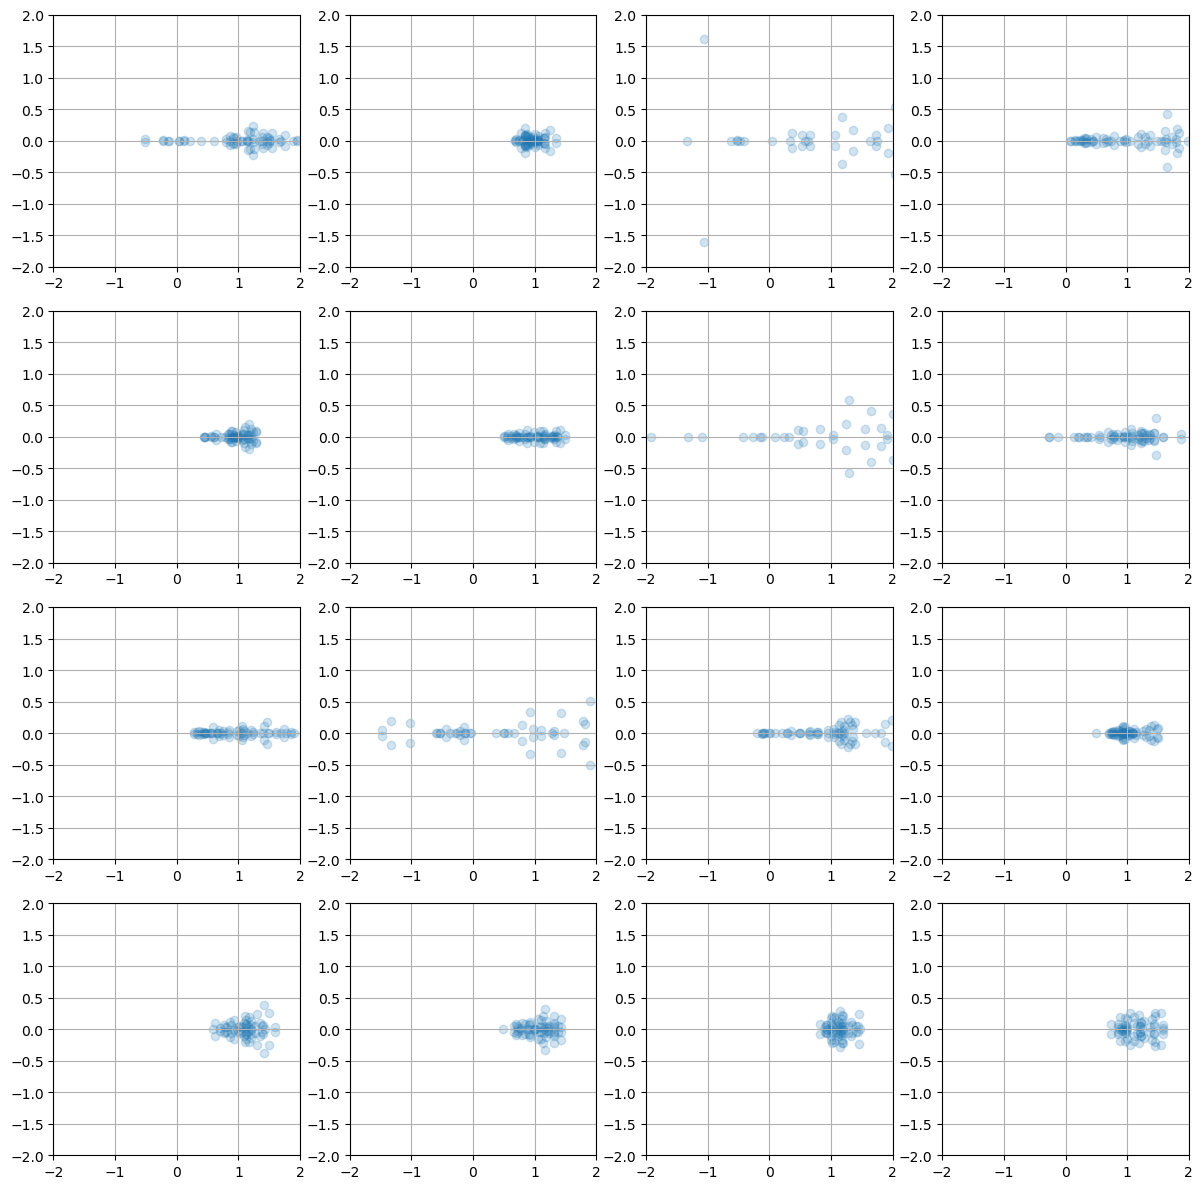

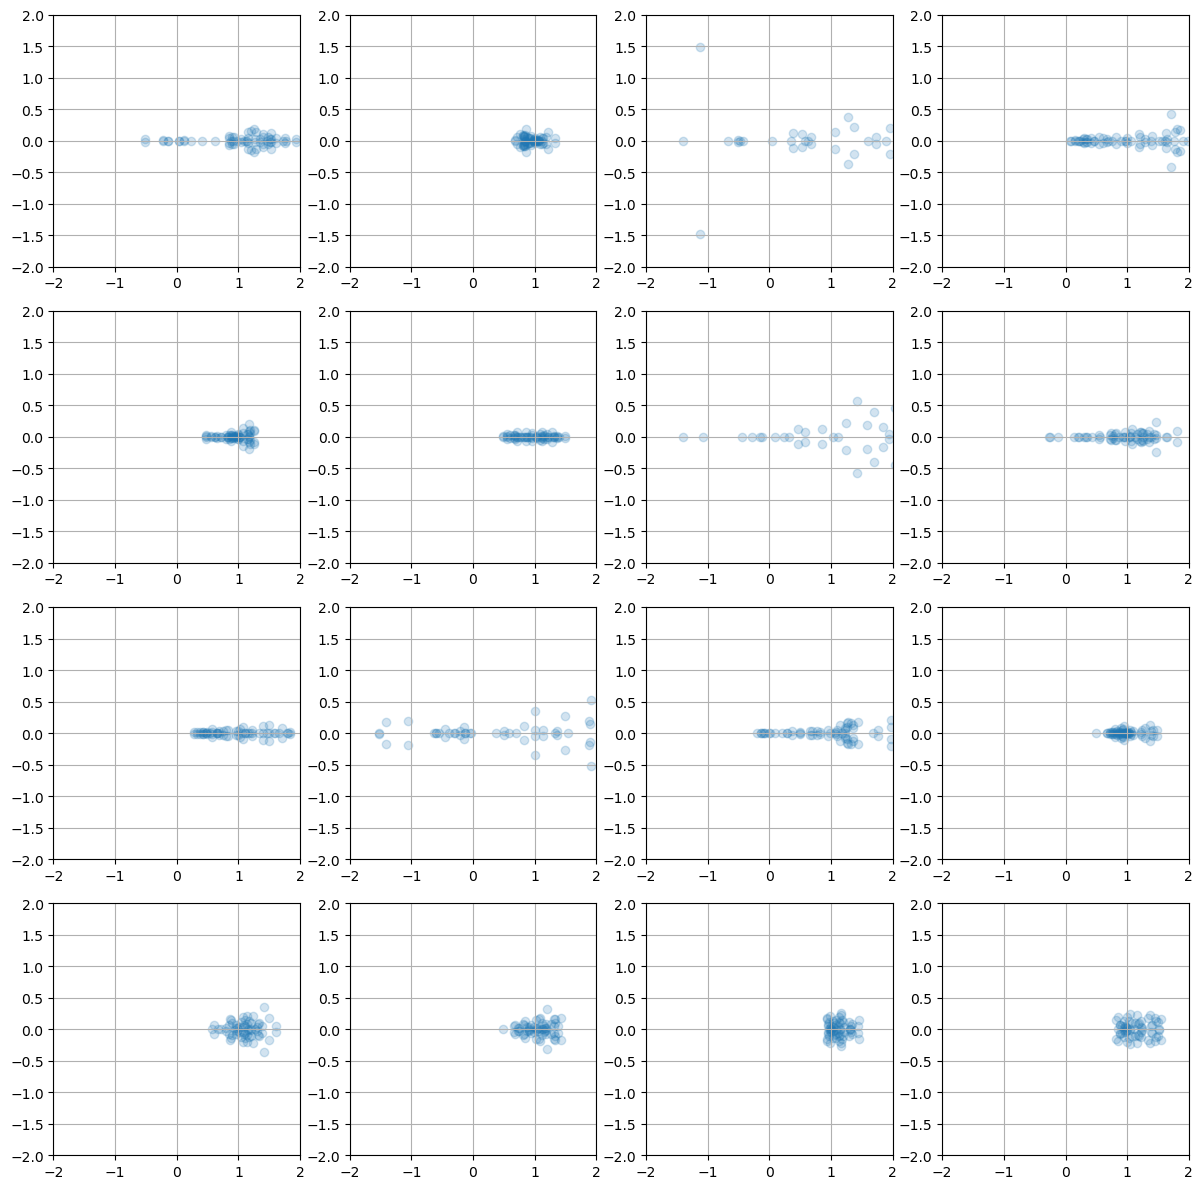

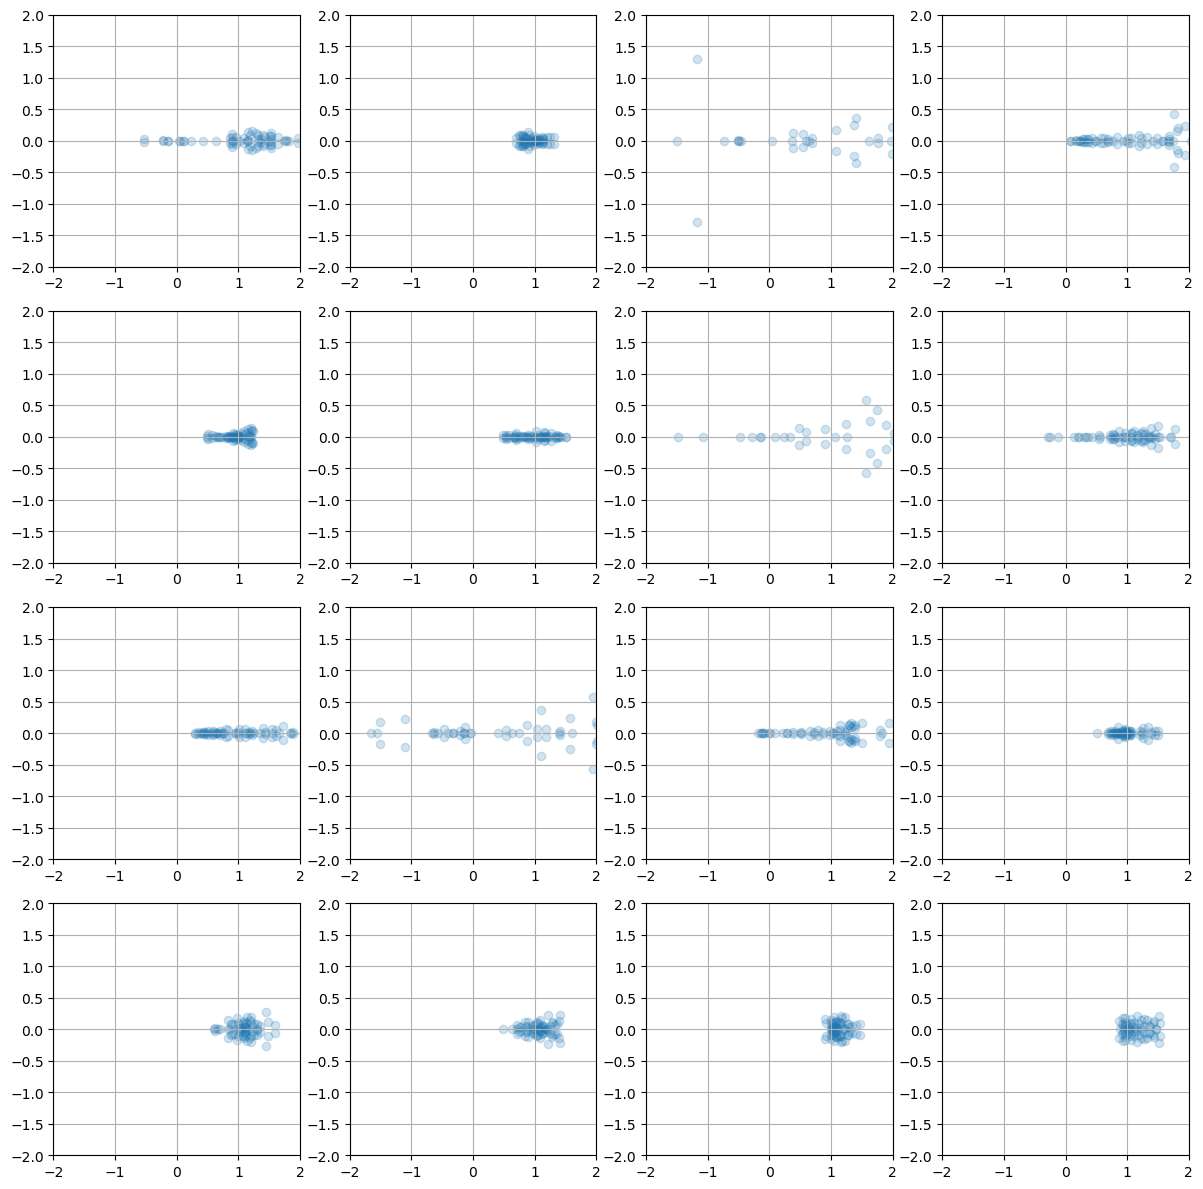

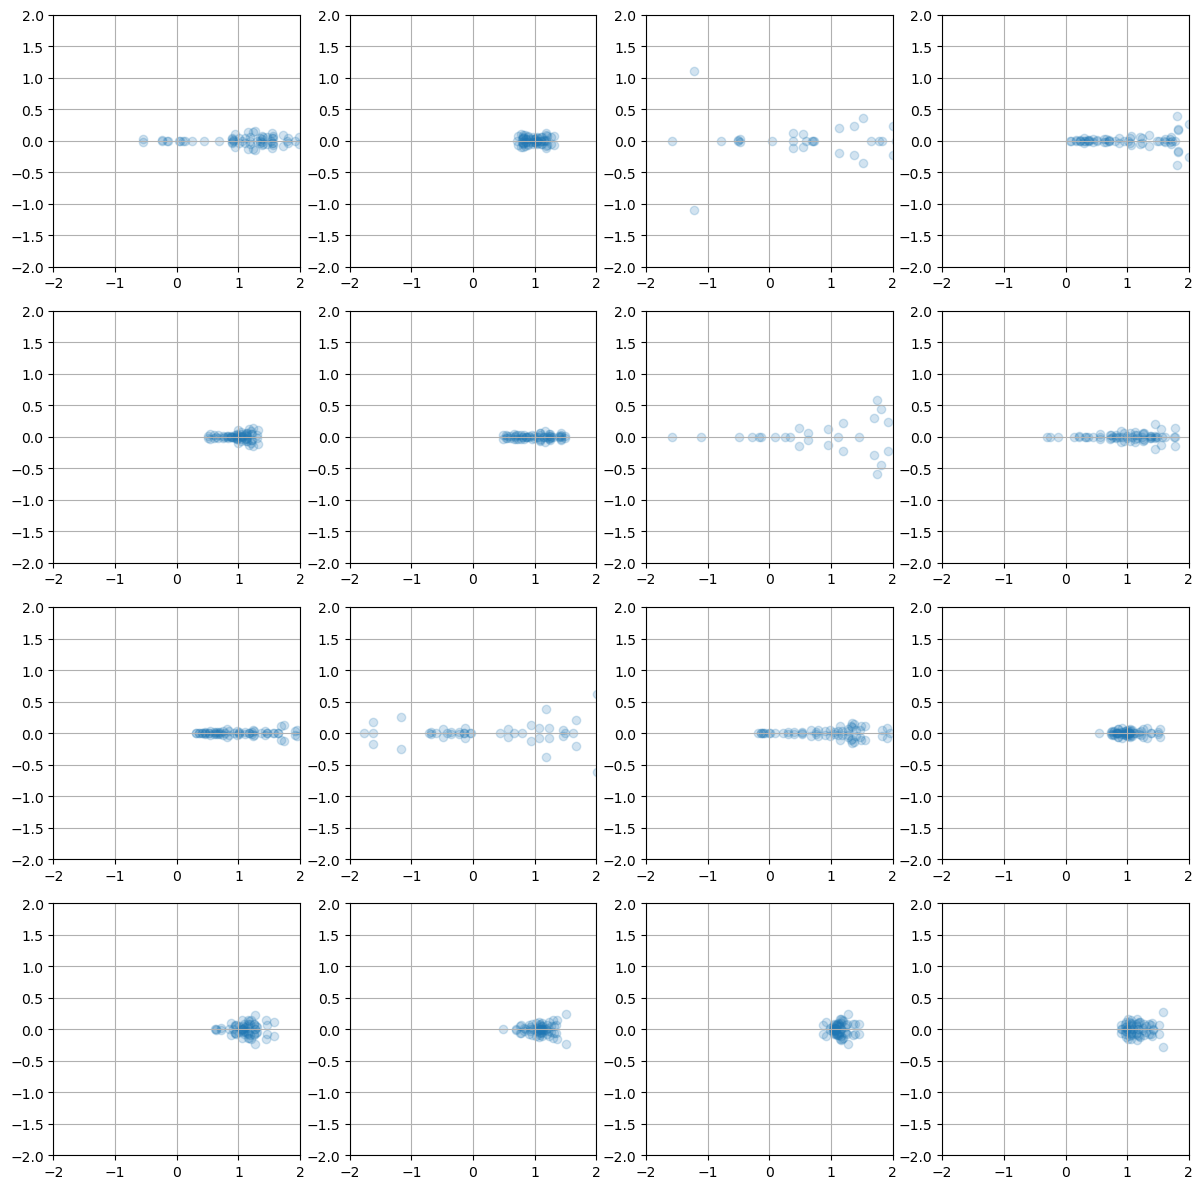

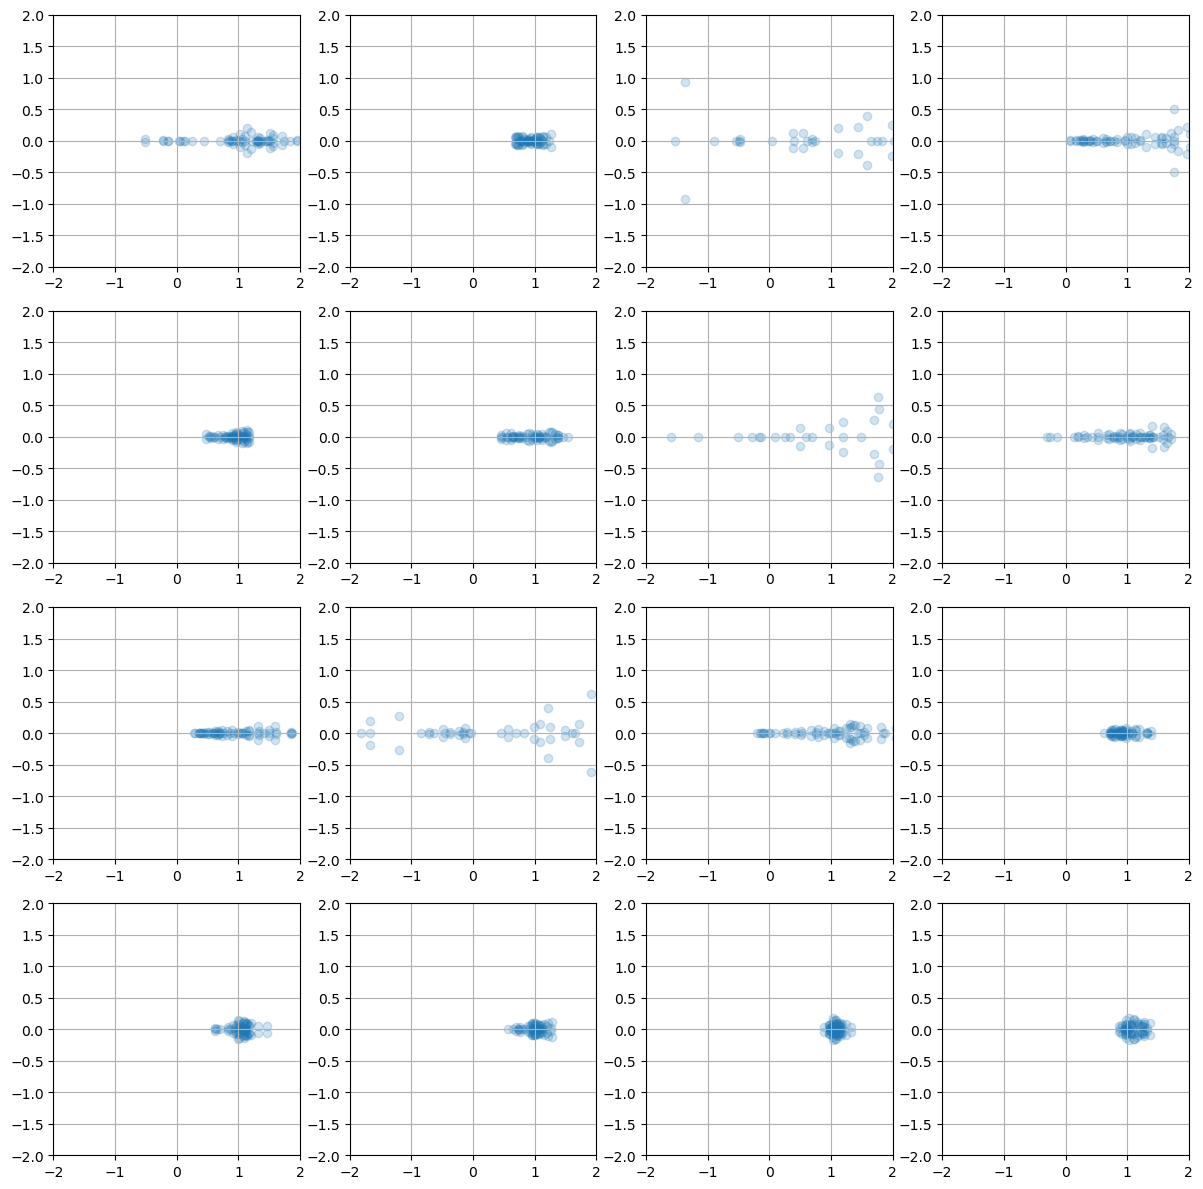

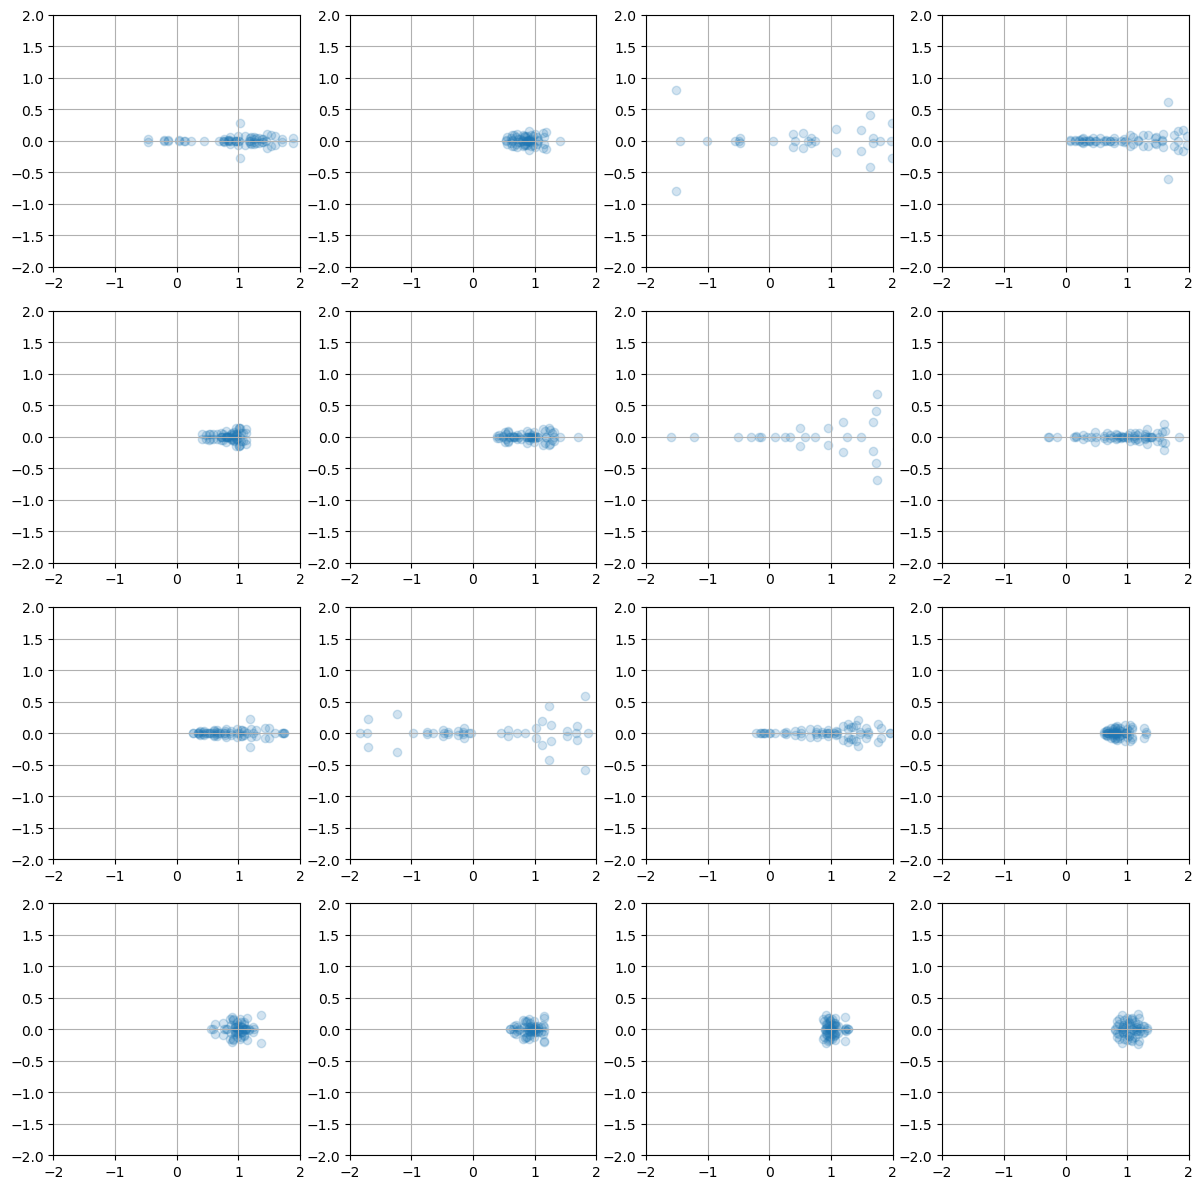

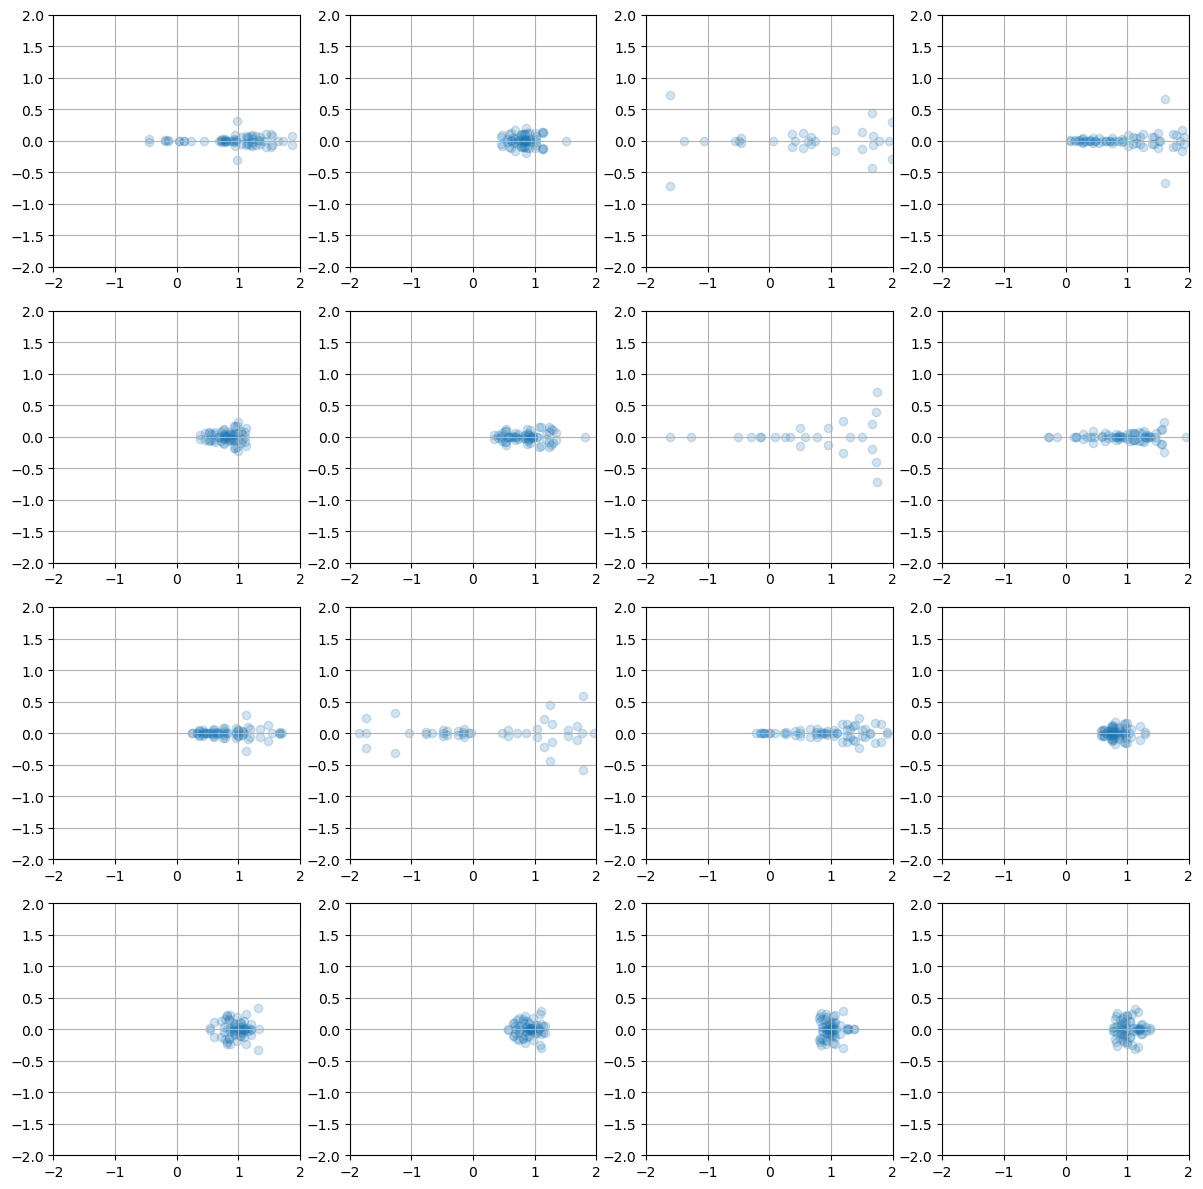

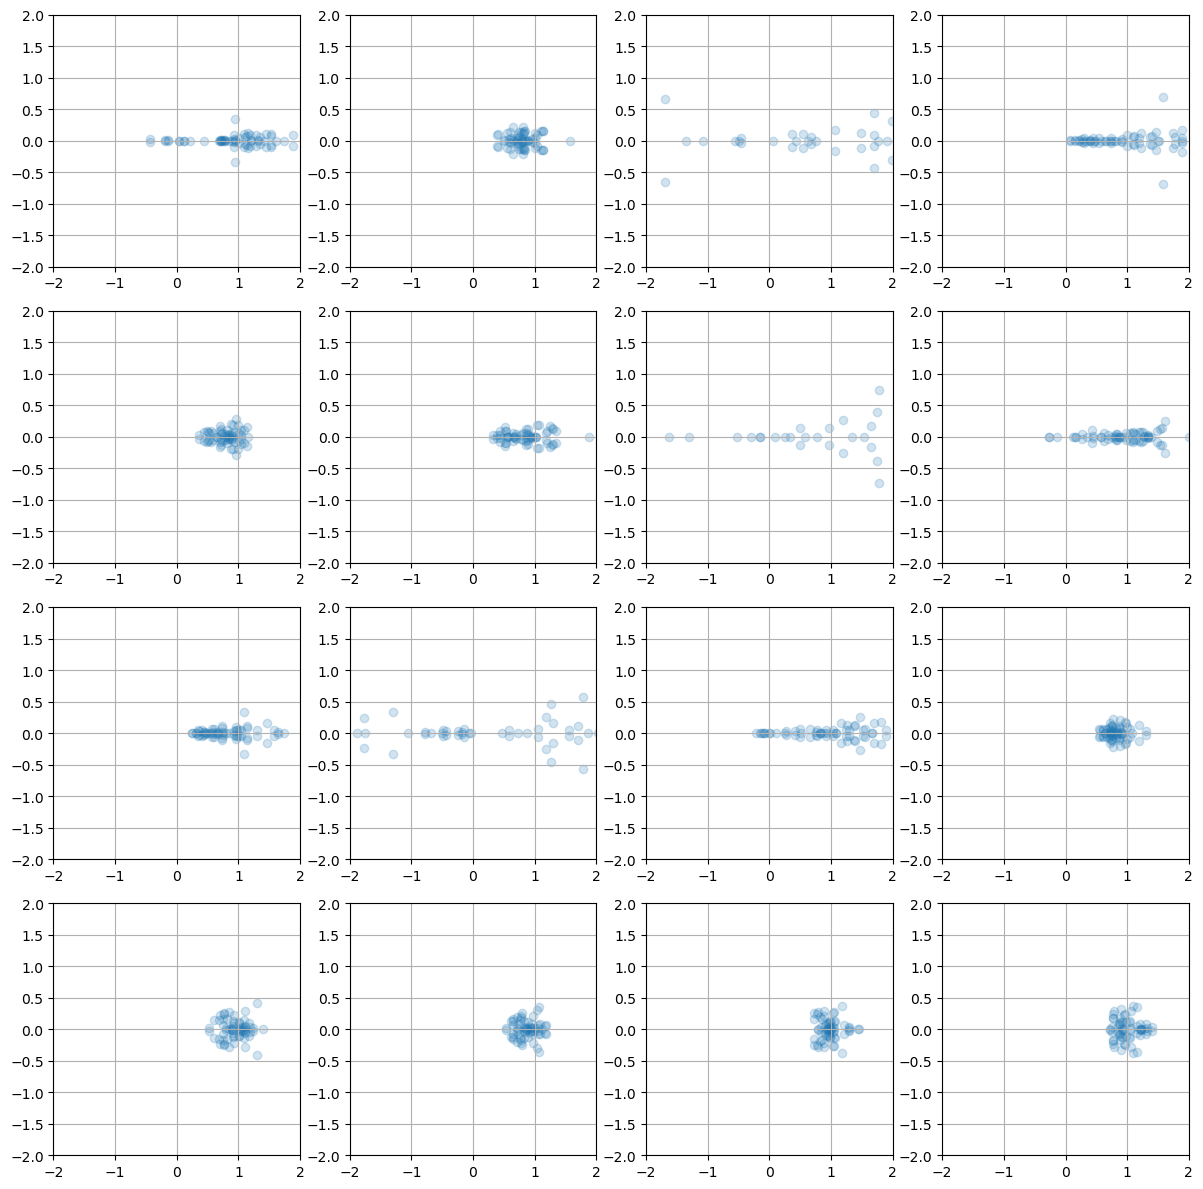

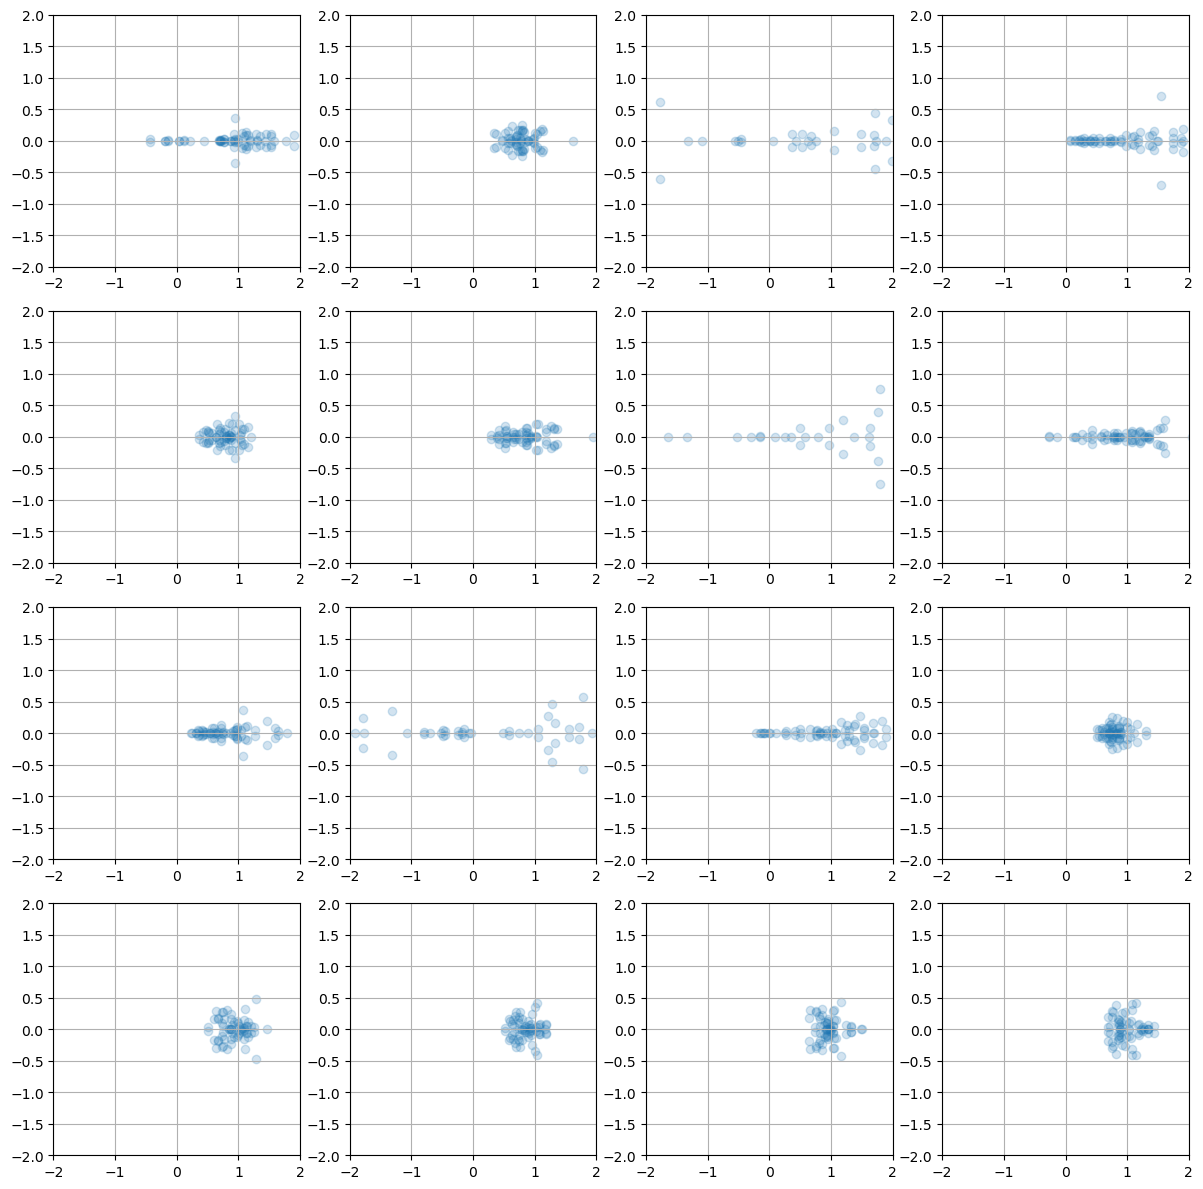

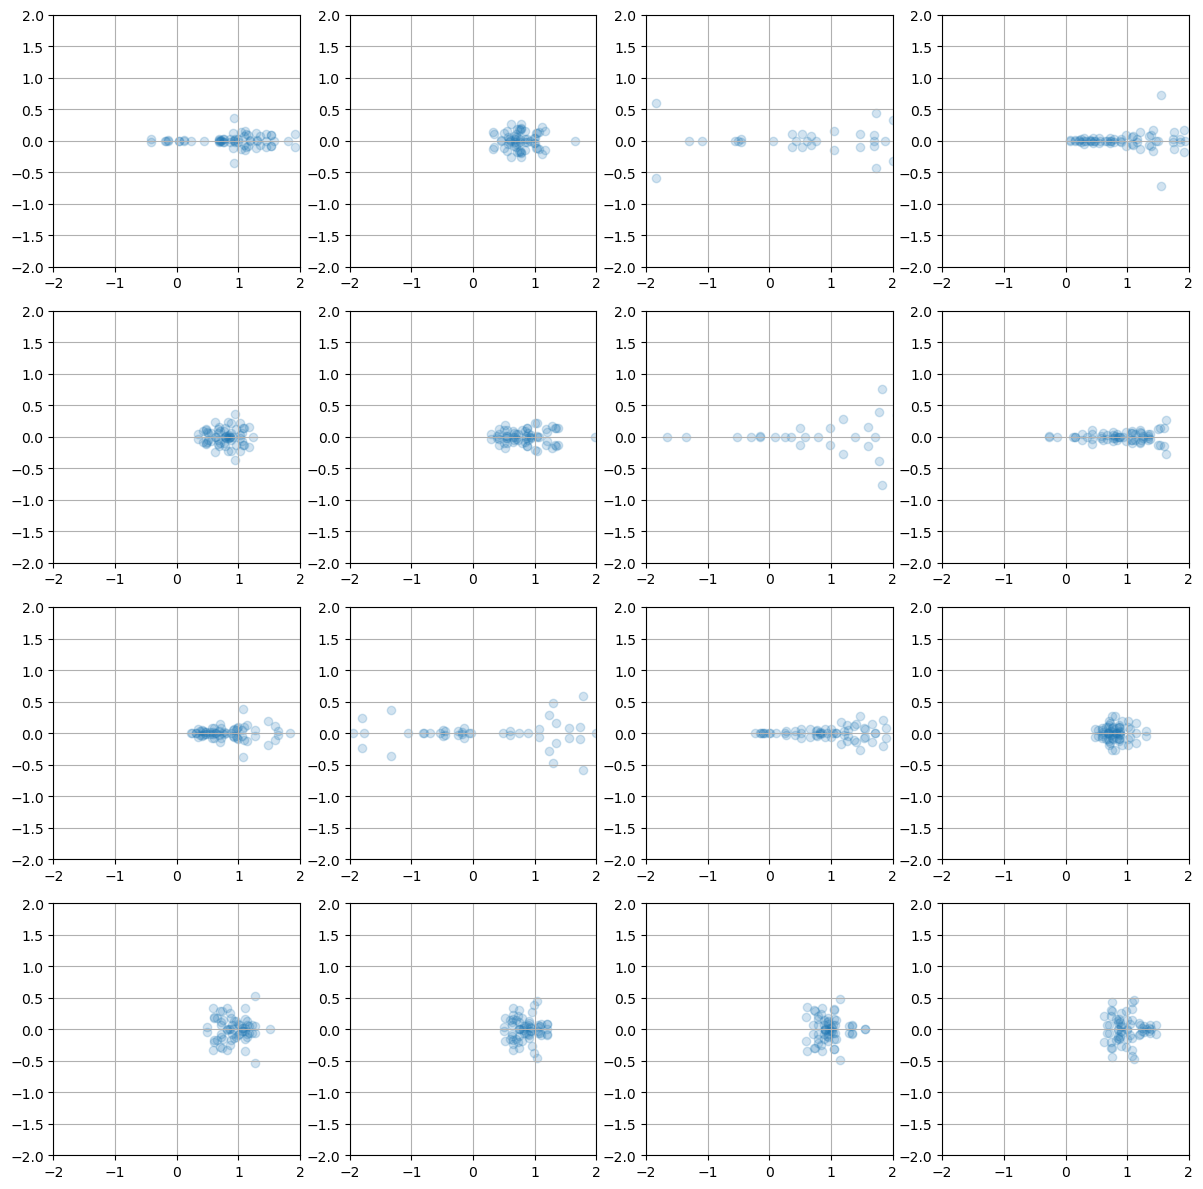

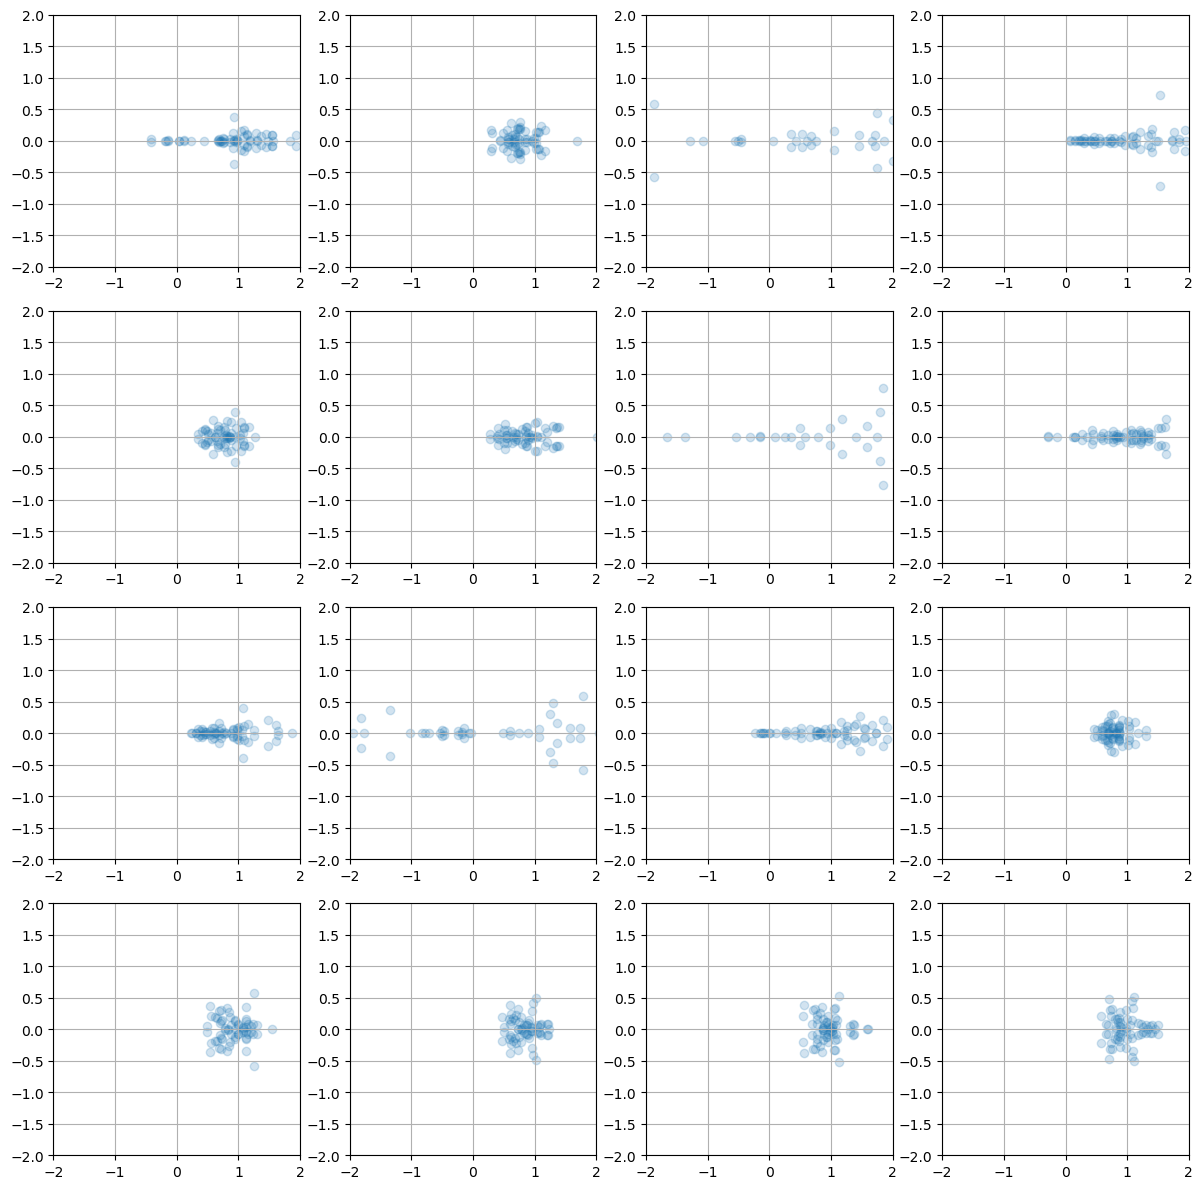

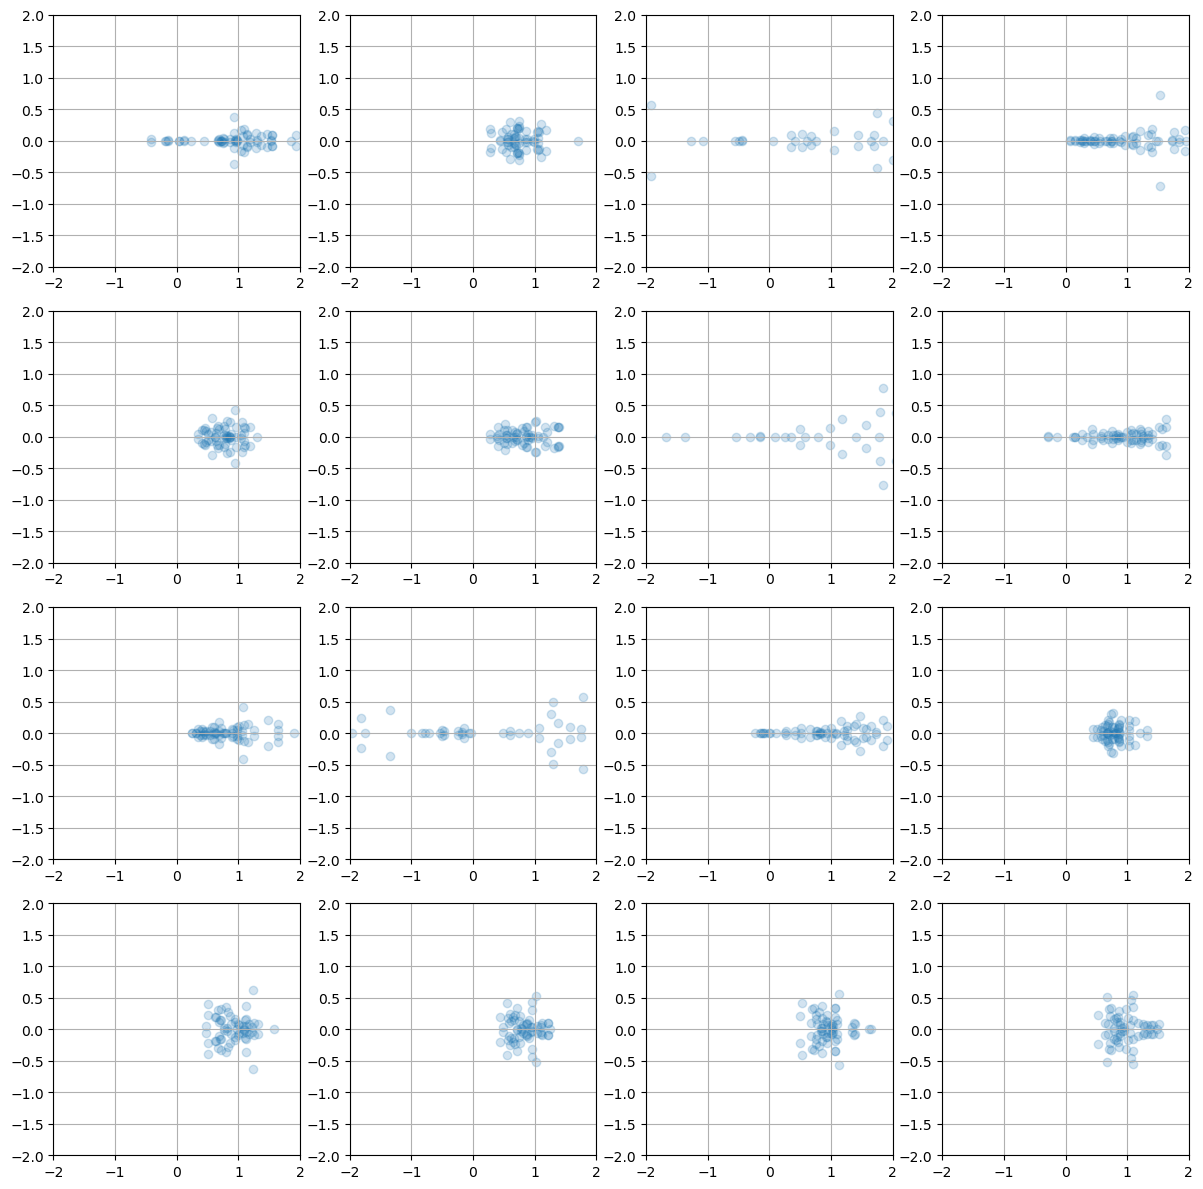

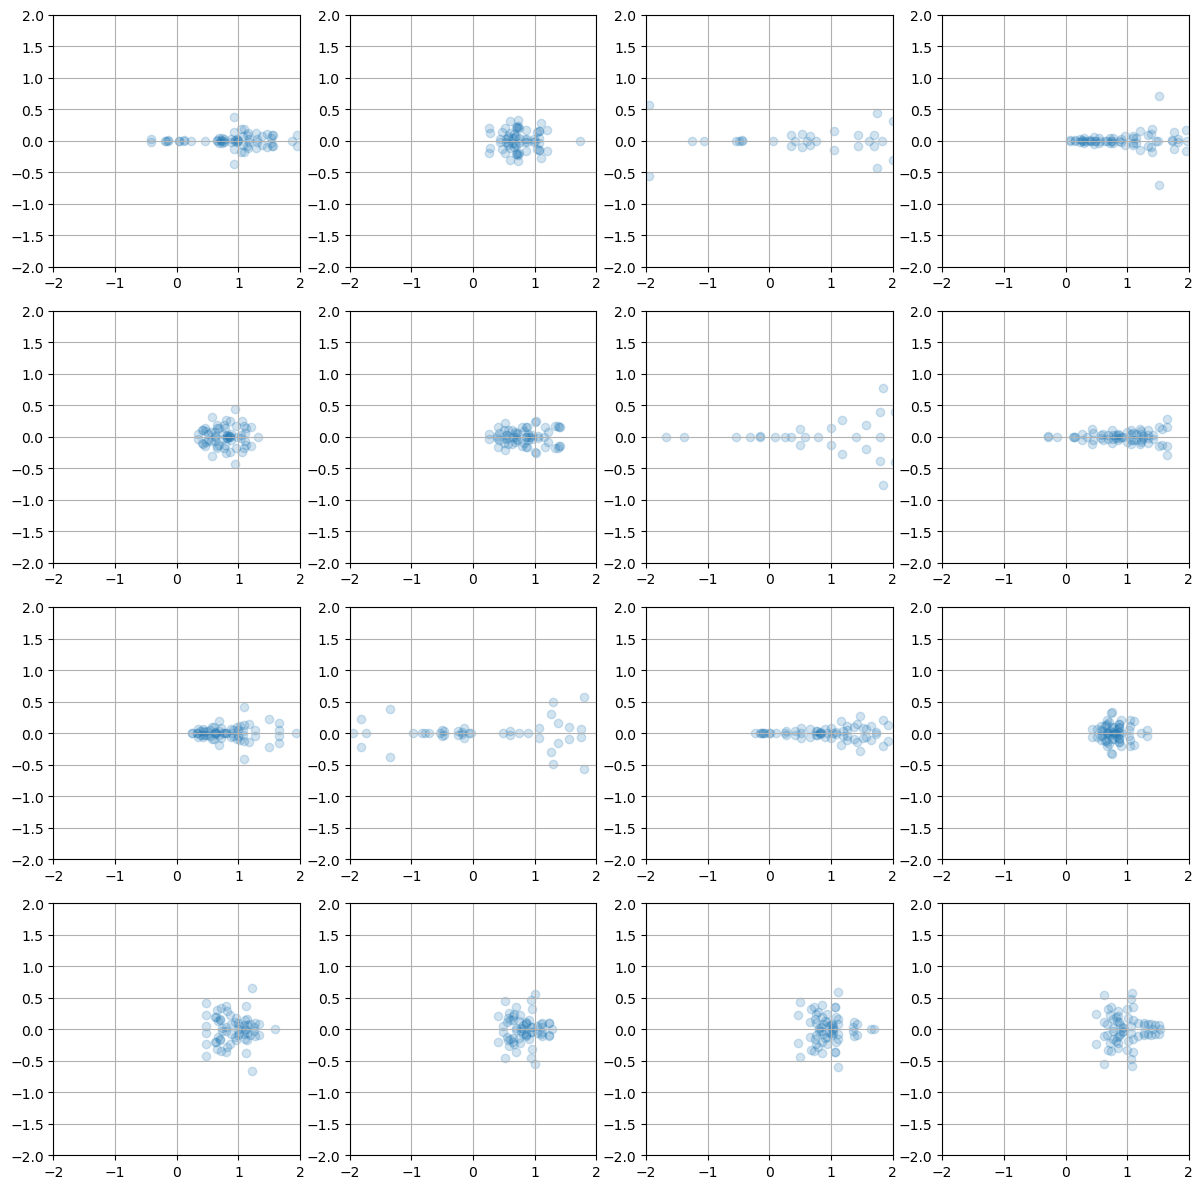

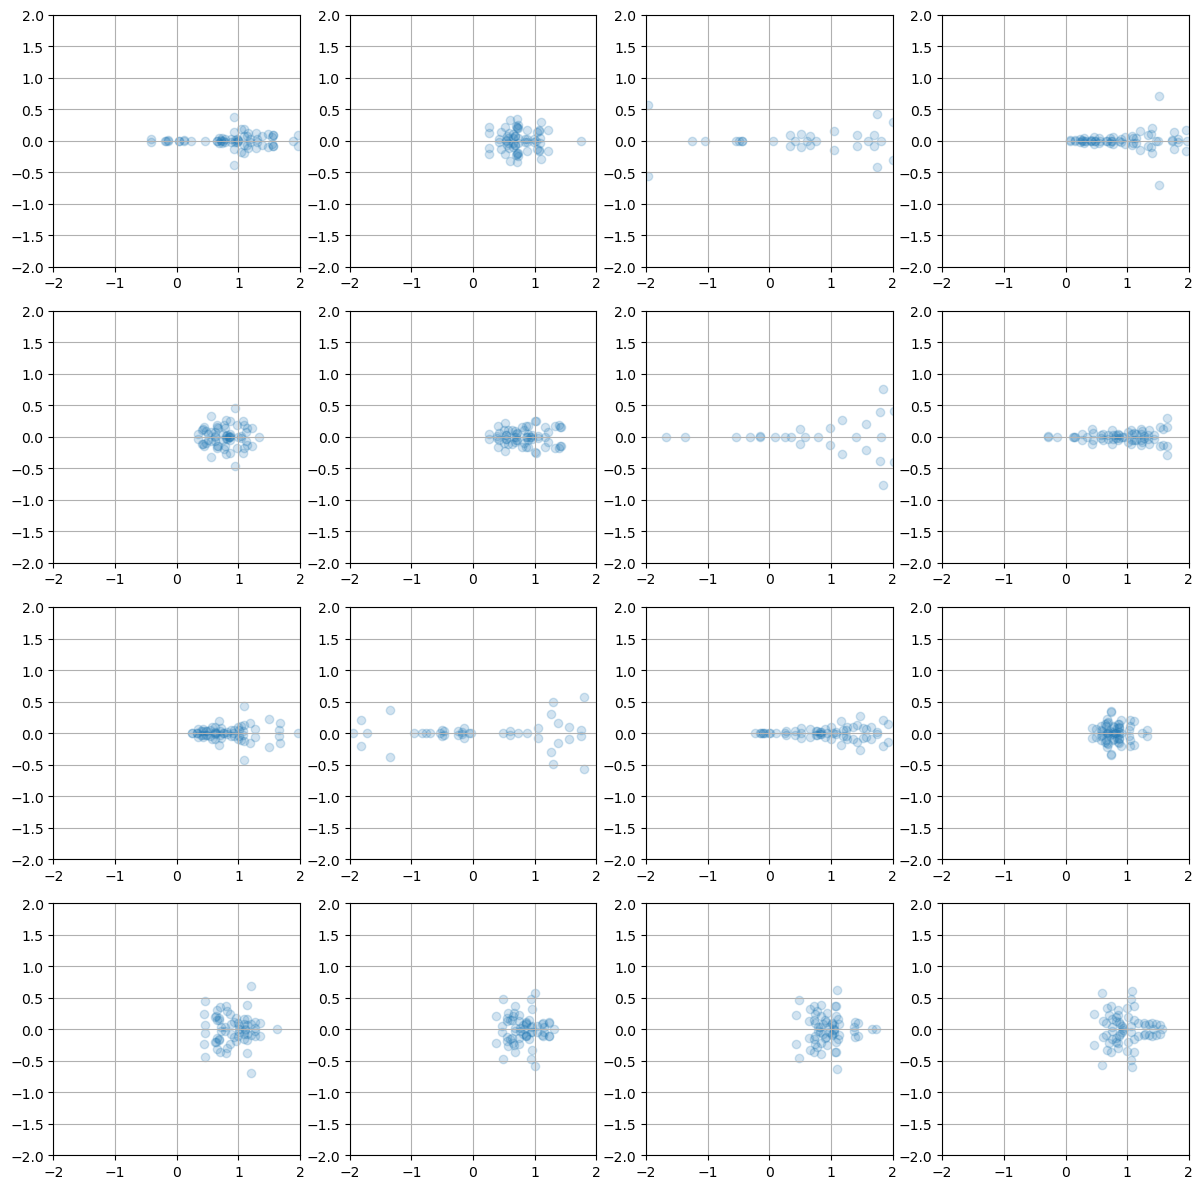

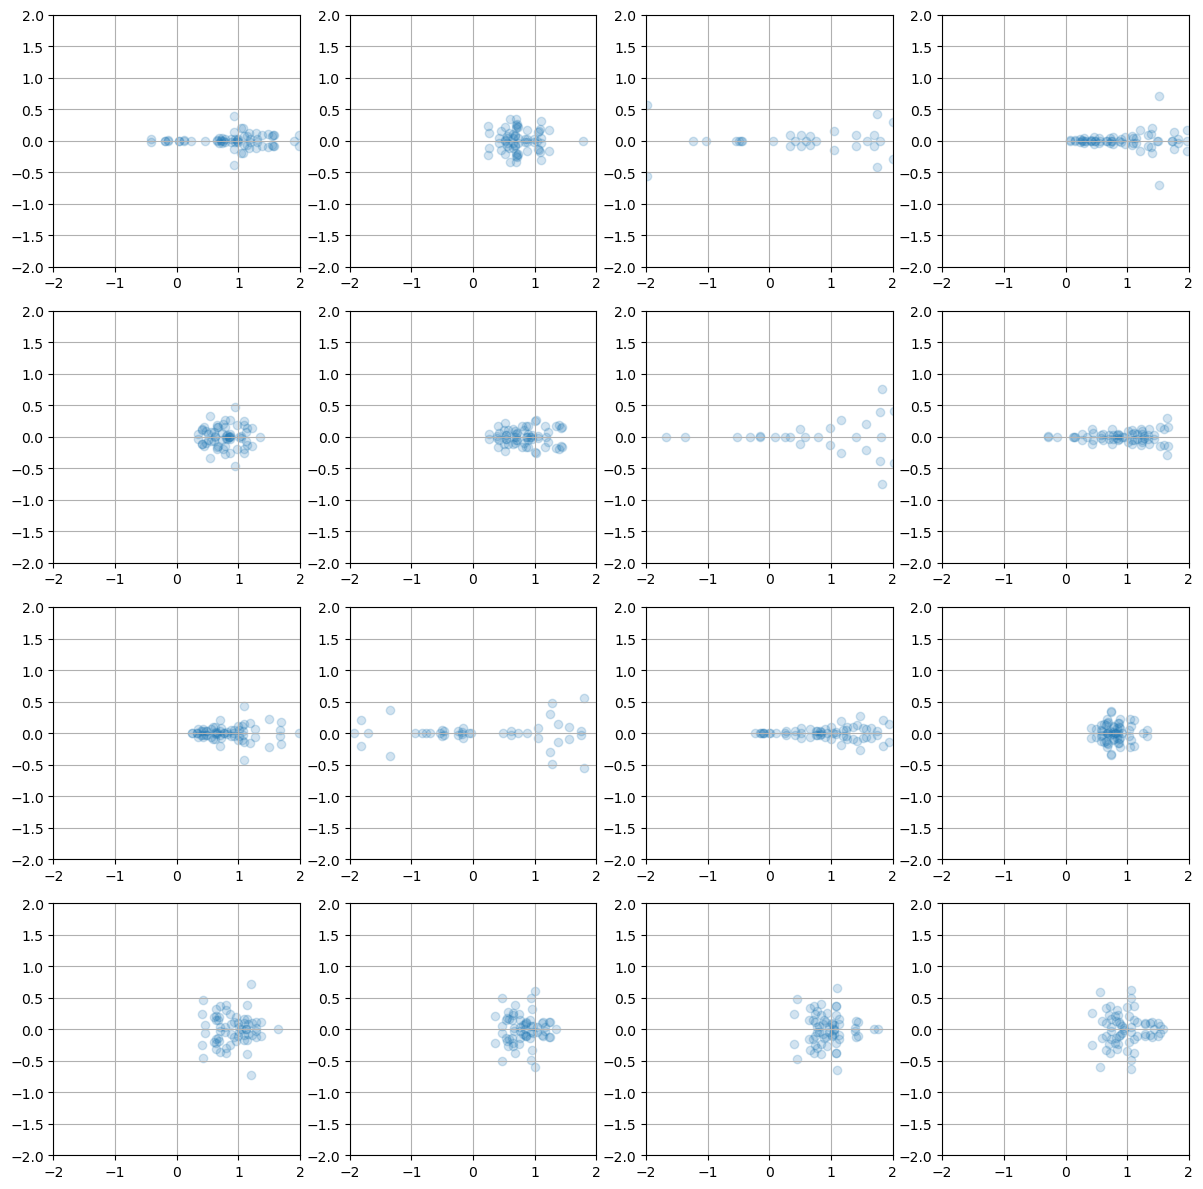

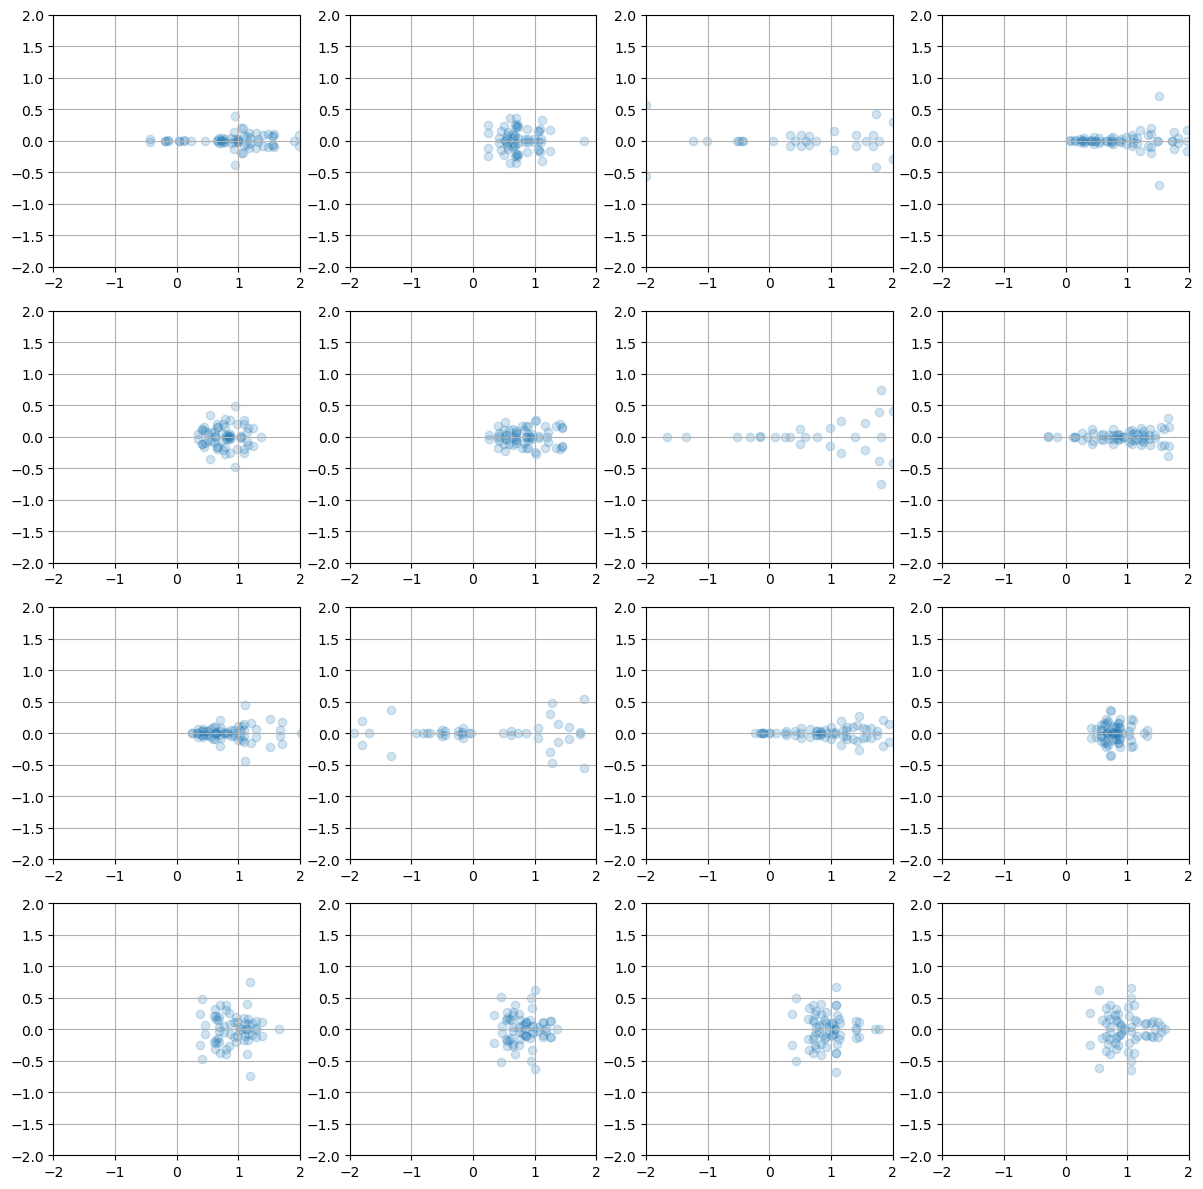

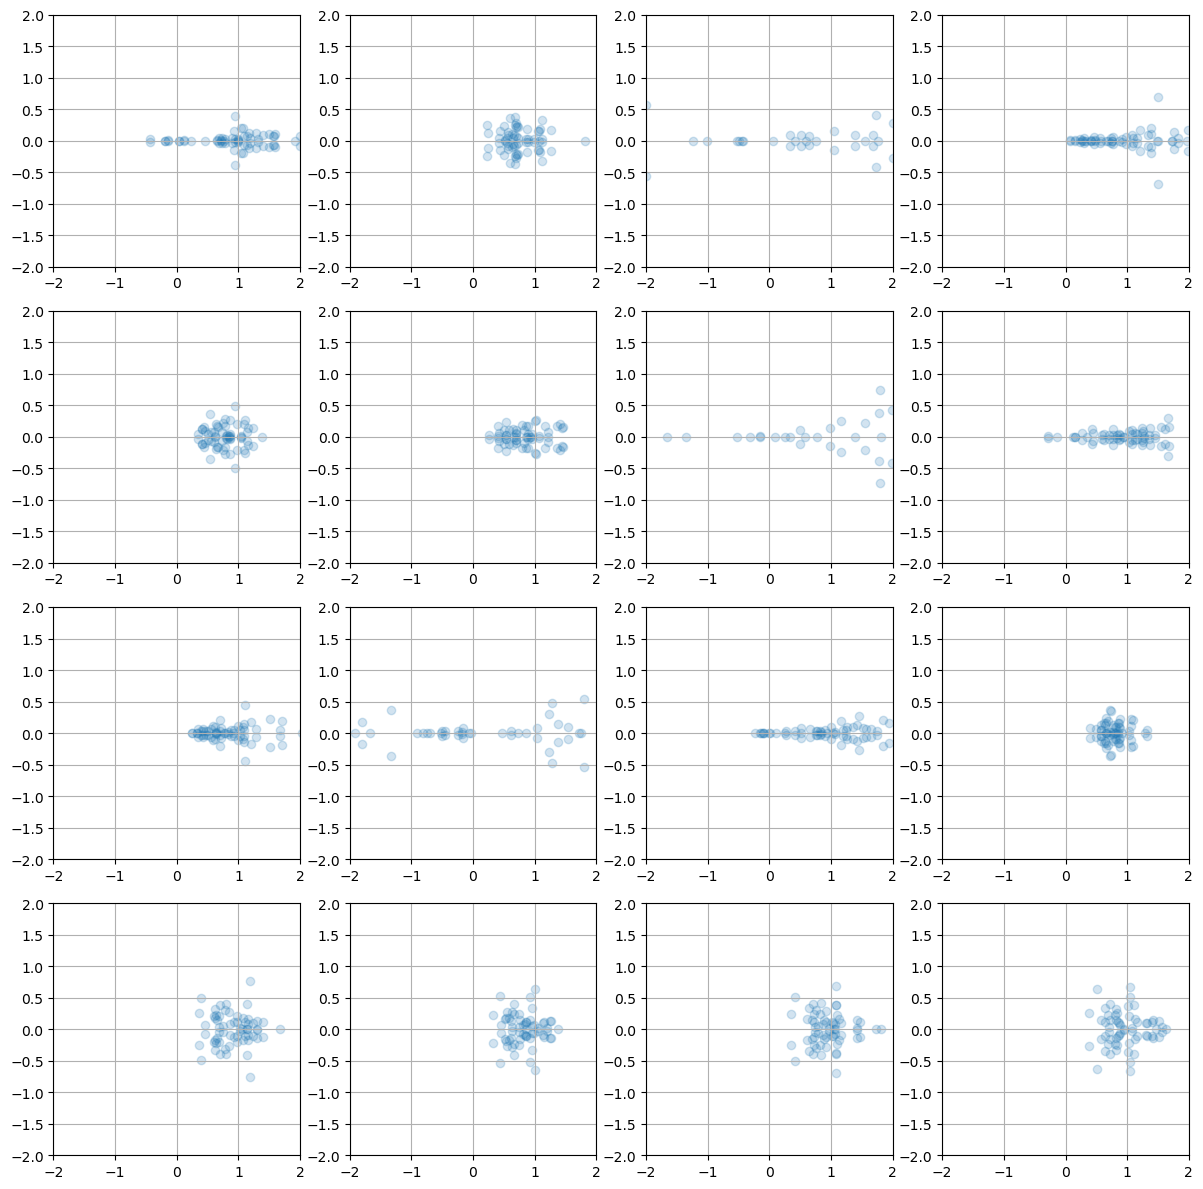

In [ ]:
train(
    epoch_num=50,
    net=net,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    device=device,
    name="GershgorinPolyRegressionLoss",
    model_name="gershgorinpolyregressionloss_model")

In [ ]:
torch.save(net.state_dict(), './gershgorinpolyregressionloss_model/model.pt')